<p align="center">
<img src="Images/sorbonne_logo.png" alt="Logo" width="300"/>
</p>

# **SCORING & ECONOMETRICS - Assignment 1**

* **Author**: Elia Landini
* **Student ID**: 12310239
* **Course**: EESM2-Financial Economics 
* **Class**: Scoring and Econometrics
* **Supervisor**: Jean-Bernard Chatelain 

### **1) PREFACE**

**OPITA** (**EVEN** rows → Training & **ODD** rows → Testing) <br>
<br> The **OPITA** (*Operating Income Over Total Assets*) ratio is a financial metric that evaluates how effectively a company is using its total assets to generate operating income. It is calculated by dividing operating income, also known as EBIT (Earnings Before Interest and Tsub_plot), by the total assets reported on the company’s balance sheet. 
$$
\text{Operating Income over Total Assets} = \frac{\text{Operating Income (EBIT)}}{\text{Total Assets}}
$$
This ratio serves as an indicator of operational efficiency, showing how well management is utilizing the company’s resources to produce core earnings before the effects of financing and taxation. A higher OPITA suggests that the company is more efficient at converting its assets into operating profit, while a lower ratio may indicate underutilization of assets or operational inefficiencies.

### **2) REQUIREMENTS SET-UP**

In [75]:
# Requirements.txt file installation
# !pip install -r requirements.txt

In [76]:
# Libraries import
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px
import openpyxl as pxl

### **3) HELPER FUNCTIONS & GENERAL VARIABLES**

In [77]:
# Variables dictionary (from acronyms to full names)
variables = {"yd": "Financial Distress", 
             "tdta":"Debt/Assets", 
             "reta":"Retained Earnings",
             "opita":"Income/Assets", 
             "ebita":"Pre-Tax Earnings/Assets", 
             "lsls":"Log Sales",
             "lta":"Log Assets" , 
             "gempl":"Employment Growth", 
             "invsls":"Inventory/Sales",
             "nwcta":"Net Working Capital/Assets", 
             "cacl":"Current Assets/Liabilities", 
             "qacl":"Quick Assets/Liabilities", 
             "fata":"Fixed Assets/Total Assets", 
             "ltdta":"Long-Term Debt/Total Assets", 
             "mveltd":"Market Value Equity/Long-Term Debt"}

In [78]:
# Inverted Variables dictionary (from full names to acronyms)
inverted_variables = {v: k for k, v in variables.items()}

In [79]:
# Statistical Significance labelling 
def significance_stars(p):
    if p < 0.001:
        return "***"  
    elif p < 0.01:
        return "**"    
    elif p < 0.05:
        return "*"   
    else:
        return ""

In [80]:
# We supress potential warnings with this command
warnings.filterwarnings("ignore")

### **4) DATA RETRIEVAL & MANIPULATION**

In [81]:
# Data Retrieval (original course dataset: defaut2000.csv)
raw_data = pd.read_csv("raw_data.csv", sep=";")

# Variable renaming (variables dictionary)
raw_data.rename(columns=variables, inplace=True)

# Convert objects (string) to numeric (float/int), as the dataset presents figures by adopting the European notation (comma as decimal separator)
for col in raw_data.columns:
    if raw_data[col].dtype == "object":
        raw_data[col] = pd.to_numeric(raw_data[col].str.replace(",", "."), errors="coerce")

pd.DataFrame(raw_data)

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
0,0,0.145539,0.383244,0.249250,0.240580,2.832563,3.196006,0.105342,0.075232,0.793606,6.452848,6.093447,0.000000,27.604182,0.027201
1,0,0.157739,0.653575,0.261918,0.215381,5.350979,5.149535,-0.002974,0.016330,0.384159,3.529916,3.398378,-99.990000,8.962069,0.237790
2,0,0.182360,0.218102,-0.053062,-0.356679,4.031815,3.970206,-0.257328,0.042915,0.437357,3.433004,3.179101,0.002600,3.644061,0.366079
3,0,0.196958,0.011139,0.221797,0.200671,4.025514,3.827649,0.205517,0.158391,0.595541,4.319132,3.243222,0.001032,27.631832,0.162987
4,0,0.202570,0.483833,0.280728,0.233083,2.443132,2.238314,-0.032192,0.237983,0.585332,6.133335,3.571832,0.051713,8.326772,0.293362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1,1.073467,-0.173055,-0.399538,-0.482151,4.397516,4.030043,-0.056461,0.305860,0.252518,1.524625,0.606991,0.588080,0.256005,0.192532
177,1,1.074797,-0.188330,-0.070062,-0.081895,4.589690,5.589196,-0.015471,0.034779,-0.220594,0.704061,0.686888,0.287900,0.131651,0.459943
178,1,1.194813,-0.687160,0.059045,0.021517,3.399509,3.175943,-0.042573,0.211297,0.243164,1.906422,0.921461,0.902017,0.257062,0.291130
179,1,1.197262,-0.216397,0.222079,0.197634,6.410458,6.435831,0.013894,0.133901,0.188765,1.655472,1.202159,0.017589,0.555134,0.209349


In [82]:
# Raw dataset descriptive statistics 
pd.DataFrame(raw_data).describe()

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,0.475138,0.558917,0.250587,0.109429,0.066021,5.728610,5.364688,-0.000717,0.173613,0.270786,2.219196,1.261482,-0.909044,1.334116,0.340090
std,0.500767,0.222044,0.280174,0.120079,0.125711,1.638786,1.668283,0.106887,0.099340,0.177900,1.073695,0.863886,10.503215,8.329777,0.165020
min,0.000000,0.108258,-0.958997,-0.399538,-0.482151,2.192304,1.703244,-0.287979,0.016330,-0.429493,0.478824,0.122656,-99.990000,-99.990000,0.027201
25%,0.000000,0.430762,0.138137,0.059856,0.021517,4.466424,3.987544,-0.056461,0.106459,0.166754,1.548995,0.769935,0.084378,0.463836,0.226291
50%,0.000000,0.541322,0.287026,0.116025,0.080512,5.697096,5.312927,0.000000,0.162897,0.257539,1.979158,1.059411,0.180382,0.925157,0.307740
75%,1.000000,0.643554,0.422355,0.184437,0.137487,6.782118,6.538129,0.041466,0.224503,0.389965,2.592360,1.482788,0.279927,1.757342,0.457466
max,1.000000,1.512991,0.835250,0.382154,0.310211,11.378750,11.017034,0.456475,0.836659,0.793606,6.838081,6.093447,0.902017,27.631832,0.804979


In [83]:
# Replace infinite values (-99.99) with NaN (missing values, ".")
raw_data.replace(-99.990000, np.nan, inplace=True)
raw_data.isna().sum()
# We observe a total of 3 NaN observations (2 for Fixed Assets/Total Assets, 1 for Long-Term Debt/Total Assets)

Financial Distress                    0
Debt/Assets                           0
Retained Earnings                     0
Income/Assets                         0
Pre-Tax Earnings/Assets               0
Log Sales                             0
Log Assets                            0
Employment Growth                     0
Inventory/Sales                       0
Net Working Capital/Assets            0
Current Assets/Liabilities            0
Quick Assets/Liabilities              0
Fixed Assets/Total Assets             2
Long-Term Debt/Total Assets           1
Market Value Equity/Long-Term Debt    0
dtype: int64

In [84]:
# Sorting by "Financial Distress" & "Income/Assets"
# Sorting first by "Financial Distress" identifies 2 groups "Default (1)" and "non-Default (1)", as the dependent variable is binary. Then, within each group a new sorting is carried on in ascending order by "Income/Assets" ratio.
# Since a lower income to total assets ratio is assumed by hypothesis to increase the probability of default, it is logic to order values in ascending order (greater to smaller)
# !!!!!!!!! (Jesse's code WRONG here, as it only sorts by target x) !!!!!!!!!! 

# Training Sample (OPITA, even rows)
# Since we have only one column for y, iloc operates only on one variable, hence, no need to specify the range of columns. Different case for the matrix X of explanatory variables, where instead, iloc must apply the filtering on each variable column (.iloc[::2, :]). As the df is still merged, we keep the most general assumption, i.e., iloc filtering of X.
df_train = raw_data.sort_values(by=["Financial Distress", "Income/Assets"], ascending= True).iloc[::2, :]

# Testing Sample (OPITA, odd rows)
# To get odd rows, .iloc must be shifted of one unit (filtering starting from line 1, instead of 0) 
df_test = raw_data.sort_values(by=["Financial Distress", "Income/Assets"], ascending= True).iloc[1::2, :]

In [85]:
# Dataframe structure control for Training Sample (OPITA)
pd.DataFrame(df_train).head(20)

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
29,0,0.402722,0.281844,-0.184475,-0.225667,5.024336,4.205525,-0.112333,0.150792,0.379230,2.207514,1.118654,0.077895,1.090941,0.285681
2,0,0.182360,0.218102,-0.053062,-0.356679,4.031815,3.970206,-0.257328,0.042915,0.437357,3.433004,3.179101,0.002600,3.644061,0.366079
16,0,0.300434,0.648204,-0.039954,-0.047786,5.764204,6.536033,0.000000,0.237458,0.082398,1.693202,0.769935,0.112903,1.637926,0.076401
75,0,0.602755,0.159501,0.033538,0.008109,3.286872,3.204271,0.022215,0.267447,0.255634,2.165768,0.841108,0.344554,2.568793,0.504544
86,0,0.643554,0.189665,0.070011,0.015917,5.896116,5.802438,-0.031254,0.285599,0.285149,1.822571,0.917791,0.284228,0.779128,0.261602
9,0,0.241411,0.390078,0.078594,0.053666,5.058597,4.632623,-0.147602,0.137904,0.344878,2.458537,1.565590,0.000000,4.708636,0.231489
81,0,0.626241,0.155820,0.081832,0.041806,5.791673,6.399216,-0.273040,0.019287,-0.007380,0.937172,0.847740,0.394493,0.504911,0.531647
77,0,0.613374,0.245858,0.088609,0.031488,7.637355,7.403428,0.051462,0.106459,0.046947,1.158059,0.705177,0.272596,0.676087,0.602477
47,0,0.482819,0.278303,0.090424,0.052307,5.420155,5.238465,0.039533,0.281394,0.436469,2.924008,1.436442,0.224495,0.873629,0.289696
72,0,0.590701,0.377665,0.092072,0.049161,4.977454,4.611913,-0.027981,0.204428,0.254221,1.932503,0.851738,0.278708,0.602478,0.442944


In [86]:
# Dataframe structure control for Testing Sample (OPITA)
pd.DataFrame(df_test).head(20)

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
62,0,0.548348,0.037796,-0.063657,-0.092025,2.243384,2.320210,0.456475,0.322593,0.350026,2.371865,1.201017,0.284639,1.471214,0.245892
87,0,0.672715,0.035095,-0.051201,-0.079017,4.102660,3.351699,-0.054518,0.167411,0.230967,1.453028,0.757208,0.066603,0.347517,0.255442
23,0,0.358284,0.292206,-0.017522,-0.079176,6.863484,5.909703,-0.001968,0.082576,0.184037,1.775137,0.872425,0.008547,0.643337,0.514217
10,0,0.251893,0.835250,0.059856,0.028479,4.327740,3.871256,0.045640,0.249495,0.443472,3.768200,1.309867,0.091691,2.790160,0.342466
70,0,0.586227,0.380840,0.077849,0.054789,6.734790,5.810835,0.052519,0.158118,0.261397,1.595038,0.688273,0.096294,0.645877,0.176342
94,0,0.799714,0.098541,0.080778,0.049869,6.595572,6.263794,-0.003018,0.238525,0.357203,2.593539,1.110780,0.566081,0.305740,0.183372
66,0,0.563403,0.178583,0.086866,0.047673,4.729964,4.393851,0.083903,0.179740,0.257539,2.059485,1.024655,0.270680,1.509353,0.482259
56,0,0.525309,0.350674,0.089093,0.040658,6.996606,6.906242,0.183009,0.095609,0.174288,5.027791,2.609307,0.418577,2.128987,0.318517
93,0,0.752616,0.164515,0.091248,0.071614,6.445087,7.199269,0.280793,0.393773,0.167443,1.682402,0.927517,0.454854,0.898622,0.323287
76,0,0.607981,0.255745,0.095521,0.071480,5.654170,4.856189,-0.025032,0.205583,0.365280,2.084331,0.728890,0.218710,0.718805,0.258767


In [87]:
# Datasets partitioning (dependent y & independent variables X)
y_train = df_train["Financial Distress"].copy()
y_test = df_test["Financial Distress"].copy()

X_train = df_train.drop(columns=["Financial Distress"]).copy()
X_test = df_test.drop(columns=["Financial Distress"]).copy()

# Matrix shape test
print(f"Training sample of X: {X_train.shape},Testing sample of X: {X_test.shape}, Training sample of y: {y_train.shape}, Testing sample of y: {y_test.shape}")

Training sample of X: (91, 14),Testing sample of X: (90, 14), Training sample of y: (91,), Testing sample of y: (90,)


### **5) STAGE 1 ANALYSIS (document C part 1)**

##### <span style="color: dodgerblue"> **5.1) What is the use of « label » in SAS et STATA? Why the instruction in the Python does not proceed exactly as in “label” in SAS and STATA? Can you find an equivalent instruction in Python and R?** </span>

The **"label"** instruction in SAS and StATA is used to attach descriptive metadata to variables (and sometimes values), helping users interpret data more easily. It is generically meant to allow the user to retrieve additional and relevant information with regards to specif variables. **Python** and **R** do not have a direct, built-in equivalent, but similar functionality can be achieved through other packages and methods (ex. **Pandas**).

- In **SAS**, the label statement is used to assign descriptive labels to variables **AND** datasets. For example, assigning label age = 'Respondent Age'; means tables and printouts will display "Respondent Age" instead of just "age", and similarly, the same concept applies to dataset titles.
- In **STATA**, there are two types of labels: "variable labels" and "value labels". **Variable labels** function like SAS—adding human-readable descriptions to variables. **Value labels** attach descriptions to the values themselves, commonly used for categorical/ordinal variables (e.g., "1=Male", "2=Female"), making outputs much easier to understand. <br>
<br>

---

<br> **Python** (especially **pandas DataFrames**) does not natively support variable or value labels as in SAS and STATA. Column names serve as identifiers, but additional descriptions must be managed externally (as comments, dictionaries, or separate metadata structures). The most common "label" term in Python refers to "label encoding," which is a preprocessing method to convert categories into numbers for machine learning, not for descriptive metadata. **Metadata** can be attached via custom DataFrame attributes, or users can maintain a parallel dictionary mapping variables to descriptions, but this approach is informal and not universally supported across all analysis and reporting functions in the Python ecosystem.

- An equivalent in **Python** with pandas, one workaround is to use the *.attrs* property to store metadata (variable labels), or to keep a separate dictionary mapping variable names to labels. For consistent metadata handling, third-party packages or project-level conventions can be developed, but this is not natively integrated.For value labels (like STATA's), pandas .Categorical can store categories, although not with attached "labels"— users can map numbers to strings using a dictionary.

<p align="center">
<img src="Images/labels_python.png" alt="pic" width="300"/>
</p>

- An equivalent in **R**, the base approach is to use factor variables to map numeric codes to levels (labels). However, R factors require all integers to be labeled and use them as value labels. For more SAS/STATA-like behavior, R packages such as haven and labelled allow users to attach "variable labels" and "value labels" as attributes to vectors. These labels are maintained as metadata and supported when importing data from SAS and STATA.

##### <span style="color: dodgerblue"> **5.2) Copy here the image in the slides of the course which signaled some variables had unexpectedly arbitrary value and comment. Copy here the Python code which replaced the observations -99 by NaN for missing observations for the related ratios.** </span>

Unexepcted abitrary values (image from course slides): 

<p align="center">
<img src="Images/unexpected_arbitrary_values_slide.png" alt="pic" width="500"/>
</p>

With regards to unexpected arbitrary values, what we observe is consistent to what early proven by the Numpy replacement of infinite values (NaN). In particular, by looking at the relative scatter plots and kernel density distributions, it is evident that the variable **TDTA** (Total Debt/Total Assets) presents a non-plausible outlier, which is in harsh contrast with the quasi-normal distribution followed by the variable data. By "non-plausible outlier", we refer to an observation's value so extreme that is unlikely, but not impossible, the case that this latter is a result of a real scenario, but rather an externality of data entry errors or coding mistakes. However, these peculiar observations belong to firms which are labeled as "non-defaulted".  Moreover, if compared to the variable mean, this isolated point is located at **-99.990000**, while the mean of observations can be found at **0.5589171447513812**, further corroborating our stance. Unexpected arbitrary values like this one often distort visualizations, leading to misleading regression lines or summary statistics. <br>

<br>

---

<br> Code to replace infinite values (-99.99) with NaN (missing values, ".") through Numpy:

<table align="center">
  <tr>
    <td><img src="Images/NaN_replace_code.png" alt="pic" width="400"/></td>
    <td><img src="Images/NaN_sum_results.png" alt="pic" width="250"/></td>
  </tr>
</table>

We observe a total of 3 NaN observations (2 for **Fixed Assets/Total Assets**, 1 for **Long-Term Debt/Total Assets**).

##### <span style="color: dodgerblue"> **5.3) For each explanatory variable in your sample of estimation copy the graphs of distributions and boxplots and report your comments on visual inspection and numbers for skewness, kurtosis, high leverage observations, non-normality for each group, equality of variance, test of equality of means and t-statistics, simple correlation coefficient with the dependent.** </span>

In [88]:
# General outlook on descriptive statistic of X within the training sample
# Count, mean, std, min, max, intra-quartiles (25th, 50th, 75th) + Skewness, Kurtosis
# We also traspose the original dataset to highlight comparability of same-class statistics among variables
X_train_desc = X_train.describe().T
X_train_desc["skewness"] = X_train.skew()
X_train_desc["kurtosis"] = X_train.kurtosis()

X_train_desc

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Debt/Assets,91.0,0.562827,0.236632,0.108258,0.431805,0.523396,0.652286,1.512991,1.084972,2.492490
Retained Earnings,91.0,0.245924,0.289365,-0.958997,0.153566,0.281844,0.403083,0.772500,-1.467408,3.660230
Income/Assets,91.0,0.111528,0.121433,-0.342578,0.060497,0.116025,0.184833,0.382154,-1.075589,2.834432
Pre-Tax Earnings/Assets,91.0,0.068082,0.128353,-0.427457,0.029066,0.077704,0.144745,0.310211,-1.390211,3.463366
Log Sales,91.0,5.687560,1.487169,2.443132,4.722502,5.658672,6.462273,10.009634,0.472407,0.628245
Log Assets,91.0,5.293930,1.532223,1.968870,4.234616,5.238465,6.292451,9.502530,0.252804,-0.105259
Employment Growth,91.0,-0.008520,0.098834,-0.273040,-0.062939,0.000000,0.036893,0.352868,0.215390,1.980276
Inventory/Sales,91.0,0.165657,0.082546,0.016330,0.107262,0.160370,0.216896,0.466175,0.706254,1.229480
Net Working Capital/Assets,91.0,0.270738,0.173786,-0.362462,0.170389,0.280069,0.376995,0.793606,-0.327358,1.898969
Current Assets/Liabilities,91.0,2.136260,0.945297,0.536236,1.557719,1.975380,2.455027,6.452848,2.101028,7.025573


**DESCRIPTIVE STATISTICS:** <br>
<br> The table above is the result of the *.describe()* command which iterates over each item (variable) of the dataset to display a broad range of general statistics, such as mean, std, min-max range and quartiles. Despite the wide range of default statistics, for the scope of our analysis, a further degree of in-depth insights was required. In order to inquire potential non-normal distributions in our raw data, we extended the analysis by including per each variable also the statistics of Kurtosis and Skewness. The two stats are derived by the formula below, through *scipy.stats* library: <br>
<br>

$$
\begin{array}{cc}
\text{Skewness: } \; 
\gamma_1 = \dfrac{\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^3}
{\left(\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2\right)^{3/2}}
&
\quad
\text{Kurtosis: } \; 
\gamma_2 = \dfrac{\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^4}
{\left(\frac{1}{n}\sum_{i=1}^n (x_i - \bar{x})^2\right)^{2}}
\end{array}
$$

<br> From the definition of **Normal PDF**, a normal distribution is characterized by a **Skewness** equal to 0 (perfectly symmetric) and a **Kurtosis** equal to 3 (a so called mesokurtic distribution). This general assumption is helpful to detect whether a variable follows a normal distribution in its observations. Following *George & Mallery (2010)*, we define a plausible or quasi normal PDF, a function presenting a Skewness (acceptable symmetry) absolute value <2, and a excess Kurtosis (acceptable tail behaviour) absolute value <7. <br>

<br> Hence, within our dataset, we observe that there is evidence of a set of explanatory variables showing a quite harsh disalignment from the theoretical normal, namely Long Term Debt/Total Assets (extreme skew and kurtosis), Market Value Equity/Long-Term Debt (acceptable skew, but negative kurtosis), Quick Assets/Liabilities (Strong skew and very sharp tails), Current Assets/Liabilities (on the hedge of acceptance fro both skew and kurtosis) and Log Assets (way off kurtosis). These variables will also be subject of further testing in the following chapters to assess whether this first glimpse of non-normality holds. However, the majority of variables satisfy the thresholds of kurtosis and skew for the approximation to the normal, albeit further tests must be carried on, before jumping to unwary conclusions. In particular, Debt/Assets, Retained Earnings, Income/Assets, Pre-Tax Earnings/Assets and Fixed Assets/Total Assets present a quite solid vicinity to normal stats both for skew and kurtosis. Still acceptable, but whose confidence interval for accounting the normality as valid might be questioned, are the distributions of Log Sales, Employment Growth, Inventory/Sales and Net Working Capital/Assets. 


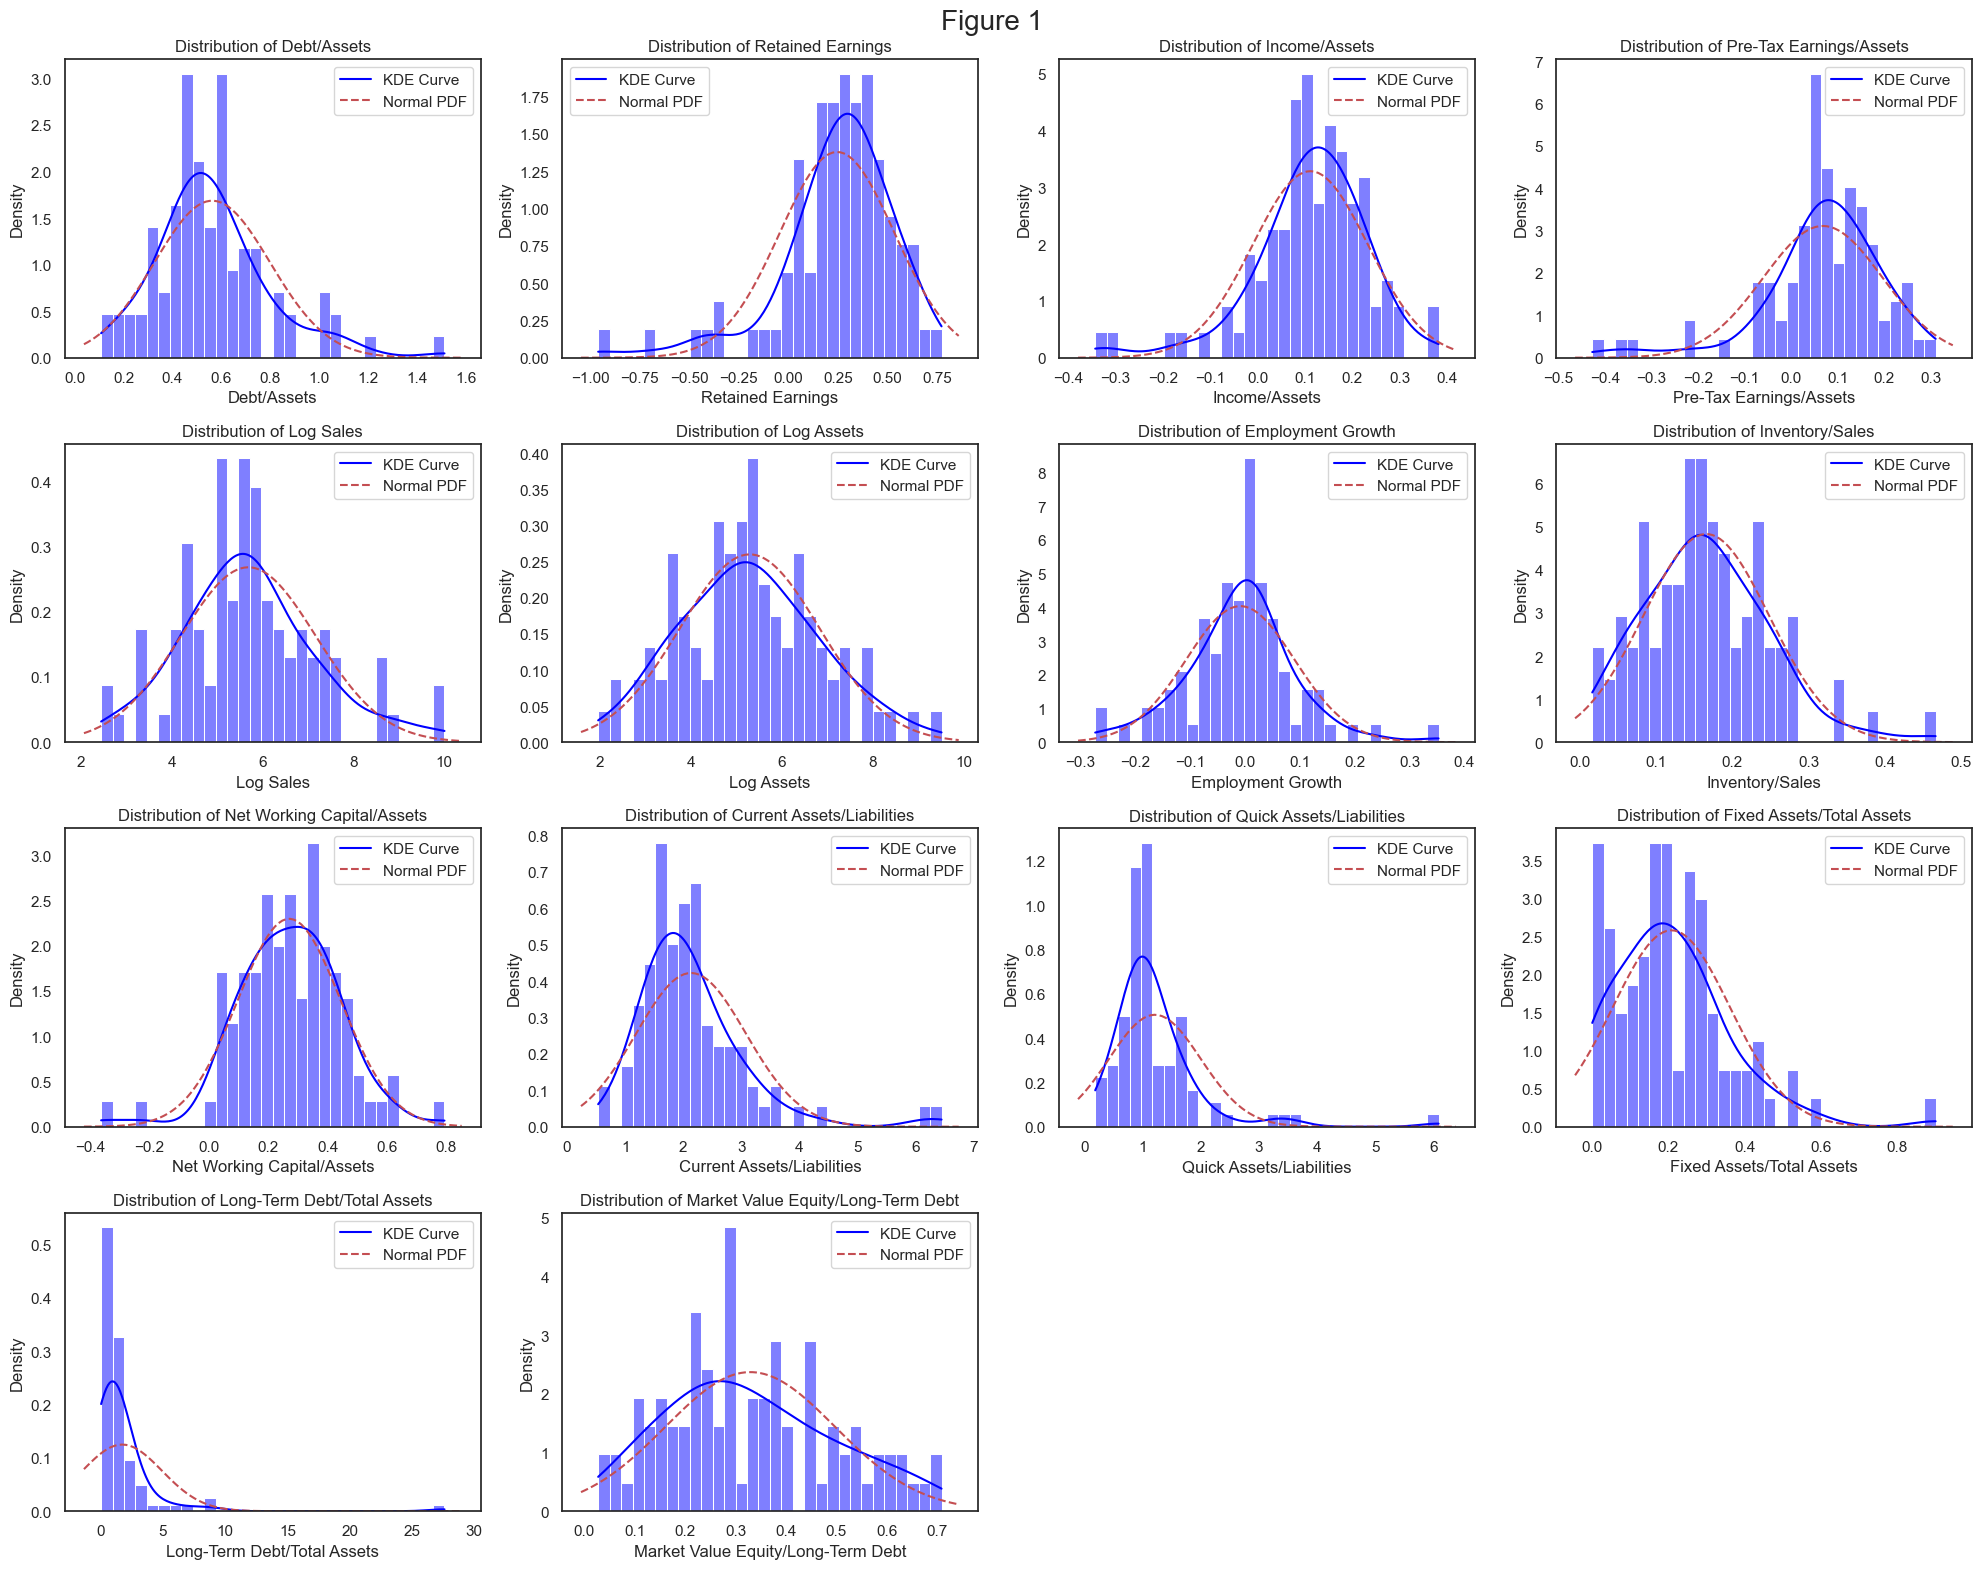

In [89]:
# Data Plotting (variable distribution with respect to the theoretical normal)
# General Layout (column and rows enumeration, figure's size, sub_plot)
num_vars = len(X_train.columns)
cols = 4
rows = (num_vars + cols - 1) // cols
fig, sub_plot = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
sub_plot = sub_plot.flatten()

# Iteration per each variable in X_train (var_i=location of the variable based on index, col_name = variable name)
for var_i, col_name in enumerate(X_train.columns):
# Kernel density distribution of i
# We discard the NaN observations we mentioned earlier
    data = X_train[col_name].dropna()
# sub_plot specs: kde curve, stat for Y sub_plot, color and number of bins (& title)
    sns.histplot(data, kde=True, ax=sub_plot[var_i], stat="density", color="blue", bins=30)
    sub_plot[var_i].set_title(f"Distribution of {col_name}")
# Normal distribution curve for comparison
    mu, std = data.mean(), data.std()
    xmin, xmax = sub_plot[var_i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    sub_plot[var_i].plot(x, p, "r--", label="Normal PDF")
# Maual labelling of KDE curve 
    lines = sub_plot[var_i].get_lines()
    if len(lines) > 0:
        lines[0].set_label("KDE Curve")
    sub_plot[var_i].legend()
# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
for j in range(var_i + 1, len(sub_plot)):
    fig.delaxes(sub_plot[j])

plt.suptitle("Figure 1", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 1:** <br>
<br> Figure 1 jointly shows for each explanatory variable the data distribution histogram, followed by an overlay of two reference curves: the Kernel Density Curve (**KDE curve**) and the respective theoretical **Normal PDF**. Moreover, the histogram has been calibrated to distribute data over 20 bins, in order to provide on one hand a comprehensive and readable representation of data frequency, while also avoid exceeding with the granularity loss. This type of representation helps to marginally corroborate our first findings on normality of data before testing. In particular, we can easily detect the lack of simmetry (exceeding Skewness) of some variables, such as Long-Term Debt/Total Assets or Distribution of Quick Assets/Liabilities, which were already labelled as critical by our first overview on data analytics. The same logic applies to abnormal tails behaviour (Kurtosis), where we often observe extreme observations leading to fatter tails or highly-stretched distributions. We will soon show how few "extremely unhealthy" firms lead to potential biases and abnormal data trends. Addressing for normality, the plotting also provides an additional layer of comparison between the actual data KDE curve (blue line) and the theoretical Normal PDF (red dot-line) having the same mean and std as the respective variable data for 100 evenly spaced points between *xmin* and *xmax*. 

With regards to frequent righ-skewed distributions (positive skew), it is worth spending few words about the economic interpretation of ratio's lower bounds and the ensuing left tails cut off. To enter in the merit of the analysis, **Quick Assets/Liabilities** and **Fixed Assets/Total Assets** are taken as examples:

**1) Ratios are bounded below but not above** <br>
    <br> Both ratios share a lower bound near 0 but have no strict upper bound. For the **Quick Assets to Liabilities** ratio, when liabilities are large, the ratio approaches 0, while when liabilities are small, the ratio can become extremely large (for example, values like 5 or 10). This creates a long right tail, as only a few firms exhibit very high liquidity levels. In the case of the **Fixed Assets to Total Assets** ratio, the numerator is always less than or equal to the denominator, so the ratio cannot exceed 1, but it can approach 0. When the denominator (total assets) is small or its composition varies, even small changes can cause disproportionate variations in the ratio, extending the right side of the distribution. As a result, data tend to cluster near the lower bound, while a few outliers stretch the right tail.


**2) Ratios amplify asymmetry** <br>

Ratios of positive variables tend to inherit and even magnify skewness. Mathematically, this can be expressed as:

$$
R = \frac{A}{B}
$$

When both *A* and *B* are positive random variables, the distribution of *R* becomes positively skewed, especially when *B* can take very small values. For instance, a few firms with particularly low liabilities may display exceptionally high liquidity ratios, producing a pronounced right-hand tail in the distribution.

**3) Economic interpretation** <br>

From an economic standpoint, firms cannot hold negative values for quick assets or liabilities, which naturally eliminates the left-hand side of the distribution and enforces a lower bound at zero. However, some firms may accumulate substantial liquid assets or maintain unusually low levels of liabilities, producing extremely high ratio values and extending the right tail of the distribution.  

A comparable mechanism operates for the Fixed Assets to Total Assets ratio. Most firms exhibit moderate proportions of fixed assets relative to their total assets, but certain firms—particularly those with capital-intensive business models—may hold an unusually large share of fixed assets. This structural characteristic again results in a **right-skewed** distribution, where extreme values appear predominantly on the upper side.

In [90]:
# Extreme observations analysis: highly affected firms
# 90th percentiles mask for each variable 
# The mask is a boolean that turns True when the value falls in the top 90% tier of observations for at least 5 variable
q90 = X_train.quantile(0.90)
mask = (X_train >= q90)
extreme_count = mask.sum(axis=1)
X_train_extreme = X_train[extreme_count >= 5]
X_train_extreme["Number of Critical Variables"] = extreme_count
X_train_extreme = X_train_extreme[["Number of Critical Variables"] + [col for col in X_train_extreme.columns if col != "Number of Critical Variables"]]
X_train_extreme

,Number of Critical Variables,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
0,7,0.145539,0.383244,0.249250,0.240580,2.832563,3.196006,0.105342,0.075232,0.793606,6.452848,6.093447,0.000000,27.604182,0.027201
1,6,0.157739,0.653575,0.261918,0.215381,5.350979,5.149535,-0.002974,0.016330,0.384159,3.529916,3.398378,NaN,8.962069,0.237790
4,6,0.202570,0.483833,0.280728,0.233083,2.443132,2.238314,-0.032192,0.237983,0.585332,6.133335,3.571832,0.051713,8.326772,0.293362
41,6,0.461447,0.439588,0.288795,0.248811,5.695460,5.193580,0.000460,0.130593,0.465743,3.208426,2.185559,0.188189,3.199885,0.323364
132,5,0.584596,0.318243,0.366768,0.310211,10.009634,9.502530,-0.011162,0.046911,0.091654,1.338066,1.050751,0.146471,0.952663,0.582215


**EXTREME OBSERVATIONS ANALYSIS: HIGHLY AFFECTED FIRMS** <br>
<br> The objective of this analysis is to inquire whether there is evidence of firms who are broadly affected by abnormal values for a large set of variables, suggesting that there is a recursive pattern of these latter in providing extreme values. It is not yet in the scope of this analysis to assess whether the affected groups of variables are correlated with each other, but the interest is rather in spotting those **extremely unhealthy**, or **extremely healthy**, firms which may bias our test statistics or alter data's tails behaviour. However, it is already predictable that an higher relative correlation coefficient among certain explanatory variables in which a firm has a particular negative ratio may highly affect also other structural components. Given the lack of simmetry of some of our regressors which are bounded below 0 (non-negative ratios, right-skewed), leading to left-tail cut-offs, we set the threshold of inclusion to the 90th quantile. 

A boolean mask was created as follow to return "*True*" when the value belonging to a certain firm for a given variable fell above the 90th quantile threshold. 
$$
\text{mask} = \text{True if } (X_{\text{train}} \ge Q_{0.90})
$$
Further, an additional constraint was added to effectively target only those firms which were chronically scoring bad for several parameters. To be consider as "extremely unhealthy" the firm must have extreme values (above the 90th quantile threshold) for at least 5 variables. 5 was considered a reasonable count for critical variable, in order to avoid drafting firms which are underperforming in a single homogenous group of highly-correlated variables, such as in the case of cacl and qacl. Among 91, 5 firms within the training sample where identified as "extremely unhealthy", and hence, potentially affecting descriptive statistics and testing. Firms, named by their index, 0 (7 critical variables), 1 (6), 4 (6), 41 (6) and 132 (5) frequently appear at the hedge of right tails, leading to either fatter tails or highly stretched distributions, when the firms' parameter value is notably differing from the median. 


In [91]:
# Extreme observations analysis: non-highly affected firms descriptive statistics
# below 90th percentiles mask for each variable 
# Here we observe how decriptive statistics and distributions plotting tend to the Normal PDF by removing potential outliers and/or exceptional values derived form highly-affected firms
X_train_cleaned_extreme = X_train[extreme_count < 5]
X_train_cleaned_extreme_desc = X_train_cleaned_extreme.describe().T
X_train_cleaned_extreme_desc["skewness"] = X_train_cleaned_extreme.skew()
X_train_cleaned_extreme_desc["kurtosis"] = X_train_cleaned_extreme.kurtosis()

X_train_cleaned_extreme_desc

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Debt/Assets,86.0,0.577505,0.231167,0.108258,0.448800,0.545579,0.675189,1.512991,1.220810,2.742401
Retained Earnings,86.0,0.233728,0.291824,-0.958997,0.122909,0.278508,0.395434,0.772500,-1.432634,3.521643
Income/Assets,86.0,0.101181,0.116374,-0.342578,0.053098,0.114088,0.171493,0.382154,-1.274454,3.370679
Pre-Tax Earnings/Assets,86.0,0.057528,0.123819,-0.427457,0.023291,0.071678,0.132804,0.284486,-1.588241,3.981415
Log Sales,86.0,5.712048,1.378524,2.639933,4.848772,5.677884,6.482945,9.816214,0.467257,0.386485
Log Assets,86.0,5.307763,1.454388,1.968870,4.266281,5.311374,6.293273,8.800619,0.140195,-0.375965
Employment Growth,86.0,-0.009707,0.100900,-0.273040,-0.068336,0.000000,0.038213,0.352868,0.233584,1.855205
Inventory/Sales,86.0,0.169392,0.081241,0.019287,0.117041,0.161870,0.218672,0.466175,0.765611,1.408521
Net Working Capital/Assets,86.0,0.259496,0.162769,-0.362462,0.169696,0.267077,0.365305,0.612242,-0.704926,1.997231
Current Assets/Liabilities,86.0,2.020198,0.693888,0.536236,1.553357,1.949403,2.313957,4.389158,0.824871,1.263001


In [92]:
X_average_stats_improvement = pd.DataFrame()
X_average_stats_improvement["Train Sample Abs Skewness Differential"] = (X_train.skew() - 0).abs()
X_average_stats_improvement["Cleaned Train Sample Abs Skewness Differential"]= (X_train_cleaned_extreme.skew() - 0).abs()
X_average_stats_improvement["Train Sample Abs Kurtosis Differential"] = (X_train.kurtosis() - 3).abs()
X_average_stats_improvement["Cleaned Train Sample Abs Kurtosis Differential"] = (X_train_cleaned_extreme.kurtosis() - 3).abs()

X_average_stats_improvement

,Train Sample Abs Skewness Differential,Cleaned Train Sample Abs Skewness Differential,Train Sample Abs Kurtosis Differential,Cleaned Train Sample Abs Kurtosis Differential
Debt/Assets,1.084972,1.220810,0.507510,0.257599
Retained Earnings,1.467408,1.432634,0.660230,0.521643
Income/Assets,1.075589,1.274454,0.165568,0.370679
Pre-Tax Earnings/Assets,1.390211,1.588241,0.463366,0.981415
Log Sales,0.472407,0.467257,2.371755,2.613515
Log Assets,0.252804,0.140195,3.105259,3.375965
Employment Growth,0.215390,0.233584,1.019724,1.144795
Inventory/Sales,0.706254,0.765611,1.770520,1.591479
Net Working Capital/Assets,0.327358,0.704926,1.101031,1.002769
Current Assets/Liabilities,2.101028,0.824871,4.025573,1.736999


In [93]:
print(f"Average Train Sample Abs Skewness Differential: {X_average_stats_improvement["Train Sample Abs Skewness Differential"].mean()}, Average Cleaned Train Sample Abs Skewness Differential: {X_average_stats_improvement["Cleaned Train Sample Abs Skewness Differential"].mean()}\nAverage Train Sample Abs Kurtosis Differential: {X_average_stats_improvement["Train Sample Abs Kurtosis Differential"].mean()}, Average Cleaned Train Sample Abs Kurtosis Differential: {X_average_stats_improvement["Cleaned Train Sample Abs Kurtosis Differential"].mean()}\nAverage Skewness Change (%): {(X_average_stats_improvement["Train Sample Abs Skewness Differential"].mean() - X_average_stats_improvement["Cleaned Train Sample Abs Skewness Differential"].mean()) / X_average_stats_improvement["Train Sample Abs Skewness Differential"].mean() * 100}\nAverage Kurtosis Change (%): {(X_average_stats_improvement["Train Sample Abs Kurtosis Differential"].mean() - X_average_stats_improvement["Cleaned Train Sample Abs Kurtosis Differential"].mean()) / X_average_stats_improvement["Train Sample Abs Kurtosis Differential"].mean() * 100}")

Average Train Sample Abs Skewness Differential: 1.467057504501909, Average Cleaned Train Sample Abs Skewness Differential: 0.9881518785243172
Average Train Sample Abs Kurtosis Differential: 5.665642406392793, Average Cleaned Train Sample Abs Kurtosis Differential: 1.5363047108464816
Average Skewness Change (%): 32.643957343729916
Average Kurtosis Change (%): 72.88383910158181


**EXTREME OBSERVATIONS ANALYSIS: HIGHLY AFFECTED FIRMS FILTERED DATASET'S DESCRIPTIVE STATISTICS** <br>
<br> The table presents standard descriptive statistics, enriched by Skewness and Kurtosis, for the training sample filtered of previously identified "highly affected" firms, i.e., firms performing above the 90th quantile for at least 5 parameters. The results show evidence of notable improvement from the original raw dataset, with a **smoothing trajectory** towards the Normal PDF for almost each regressor. It is not surprising the tendency of statistics to allign towards the theoretical normal when samples are purified of their most median-distant observations, while it is worth of notice the magnitiude to which this smoothing appears.

By removing only 5 firms, we observe an average marginal improvement of Skewness of approximately **32.64%** from the original train sample to the cleaned one, and an average two-fold impact on Kurtosis, with a percentage change from origin tapering around **72.88%**. The percentage improvements were computed by comparing the average of absolute single variable's differential of Skewness and Kurtosis from the Normal PDF assumed stats, i.e., Skewness equal to 0, and Kurtosis equal to 3. In particular, from an original Skewness differential of **1.46**, we moved to roughly **0.98**, approching the normal zero value, while the Kurtosis diffrential shrinked from quota **5.67** to only **1.54**. 

While for some variables the improvement in both simmetry and tails behaviour is rather negligible, as in the cases of Market Value Equity/Long-Term Debt or Fixed Assets/Total Assets, for others, the magnitude of change in differential is notably pronounced. Variables, such as **Long-Term Debt/Total Assets** or **Quick Assets/Liabilities**, experience respective reductions of Skewness from 6.37 to 2.19 (**-65.62%**) or from 3.37 to 1.28 (**-62.01%**), as well as contractions of Kurtosis from 49.08 to 5.88 (**-88.01%**) or either from 16.74 to 3.77 (**-77.48%**).

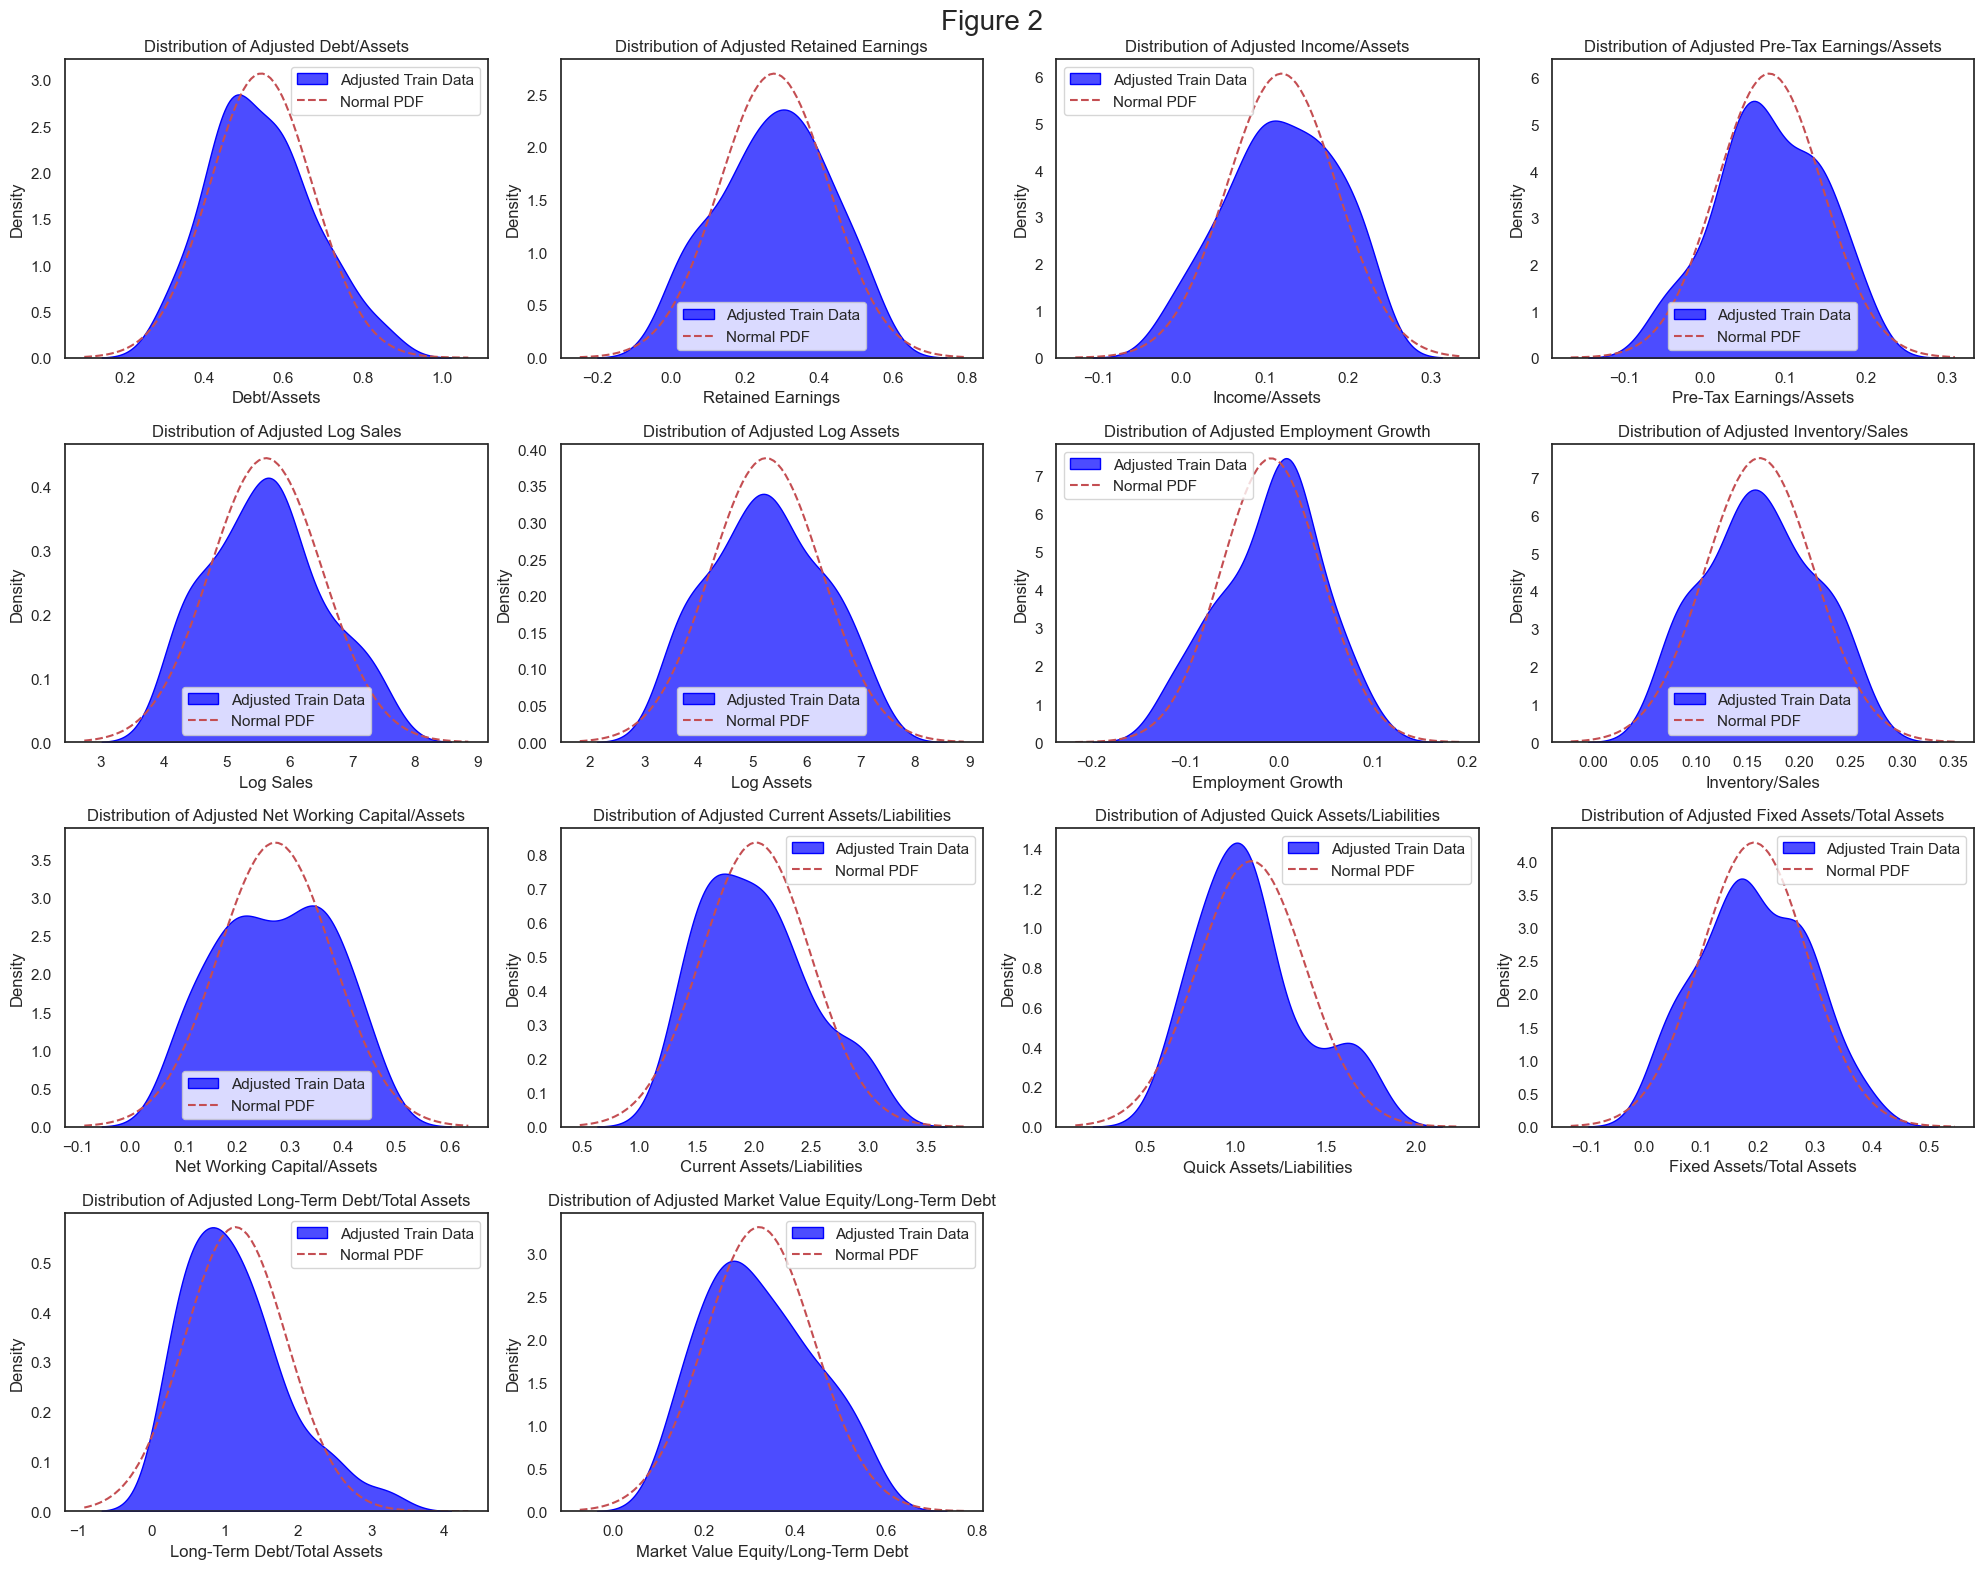

In [94]:
# Adjusted Data Plotting to potential outliers (variable distribution cleaned of 10th and 90th exceding percentile observations, outliers cleaning) 
# Cleaned dataset (-outliers outside 10th and 90th percentile)
adj_X_train = X_train.copy()
for var in X_train.columns:
    lower = X_train[var].quantile(0.10)
    upper = X_train[var].quantile(0.90)
    adj_X_train[var] = np.where(
        (adj_X_train[var] < lower) | (adj_X_train[var] > upper),
        np.nan,
        adj_X_train[var]
    )

# General Layout (column and rows enumeration, figure's size, sub_plot)
num_vars = len(X_train.columns)
cols = 4
rows = (num_vars + cols - 1) // cols
fig, sub_plot = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
sub_plot = sub_plot.flatten()

# Iteration per each variable in X_train (var_i=location of the variable based on index, col_name = variable name)
for var_i, col_name in enumerate(X_train.columns):
# Kernel density distribution of i
# We discard the NaN observations we mentioned earlier
    data = adj_X_train[col_name].dropna()
# sub_plot specs: kde curve, stat for Y sub_plot, color and number of bins (& title)
    sns.kdeplot(x=data, ax=sub_plot[var_i], fill=True, alpha=0.7, color="blue", label="Adjusted Train Data")
    sub_plot[var_i].set_title(f"Distribution of Adjusted {col_name}")
# Normal distribution curve for comparison
    mu, std = data.mean(), data.std()
    xmin, xmax = sub_plot[var_i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    sub_plot[var_i].plot(x, p, "r--", label="Normal PDF")
    sub_plot[var_i].legend()
# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
for j in range(var_i + 1, len(sub_plot)):
    fig.delaxes(sub_plot[j])

plt.suptitle("Figure 2", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 2:** <br>
<br> Following our previous analysis on **highly affected firms**, the figure plots the adjusted distribution for each variable, by removing extreme values located at the hedge of tails, beyond the 10th and 90th quantiles thresholds. Against what just discussed, the scope of both **data trimming** and **plotting** at this stage is to carve the KDE curve from those observations exhibiting higher variability from sample mean. This allows us to investigate to what extent the distribution is attributable to a Normal PDF within the range 10th to 90th quantile of observations. Within this radius, values tend to progressively cluster around the mean and hence, present a lower differential with respect to this latter (decreasing std function towards the mean center). The central region, often simmetry axis, is informative to assess where we observe the most probable data behaviour. 

From a **diagnostic perspective**, each sub-plot helps evaluate how closely each adjusted variable conforms to normality, revealing residual asymmetries or kurtosis that might affect subsequent modeling stages. In accordance to what proven earlier in the normality evaluation through Skewness and Kurtosis comparison, variables such as Pre-Tax Earnings/Assets, Income/Assets, Employment Growth, and Debt/Assets display shapes that closely approximate the normal curve, indicating stable and homogeneous behavior within the trimmed range. However, despite a solid imporvement from raw data, variables like Net Working Capital/Assets, Quick Assets/Liabilities, and Market Value Equity/Long-Term Debt retain mild **right skewness** or **bimodality**. Bimodality will be further addressed in a dedicated chapter. 

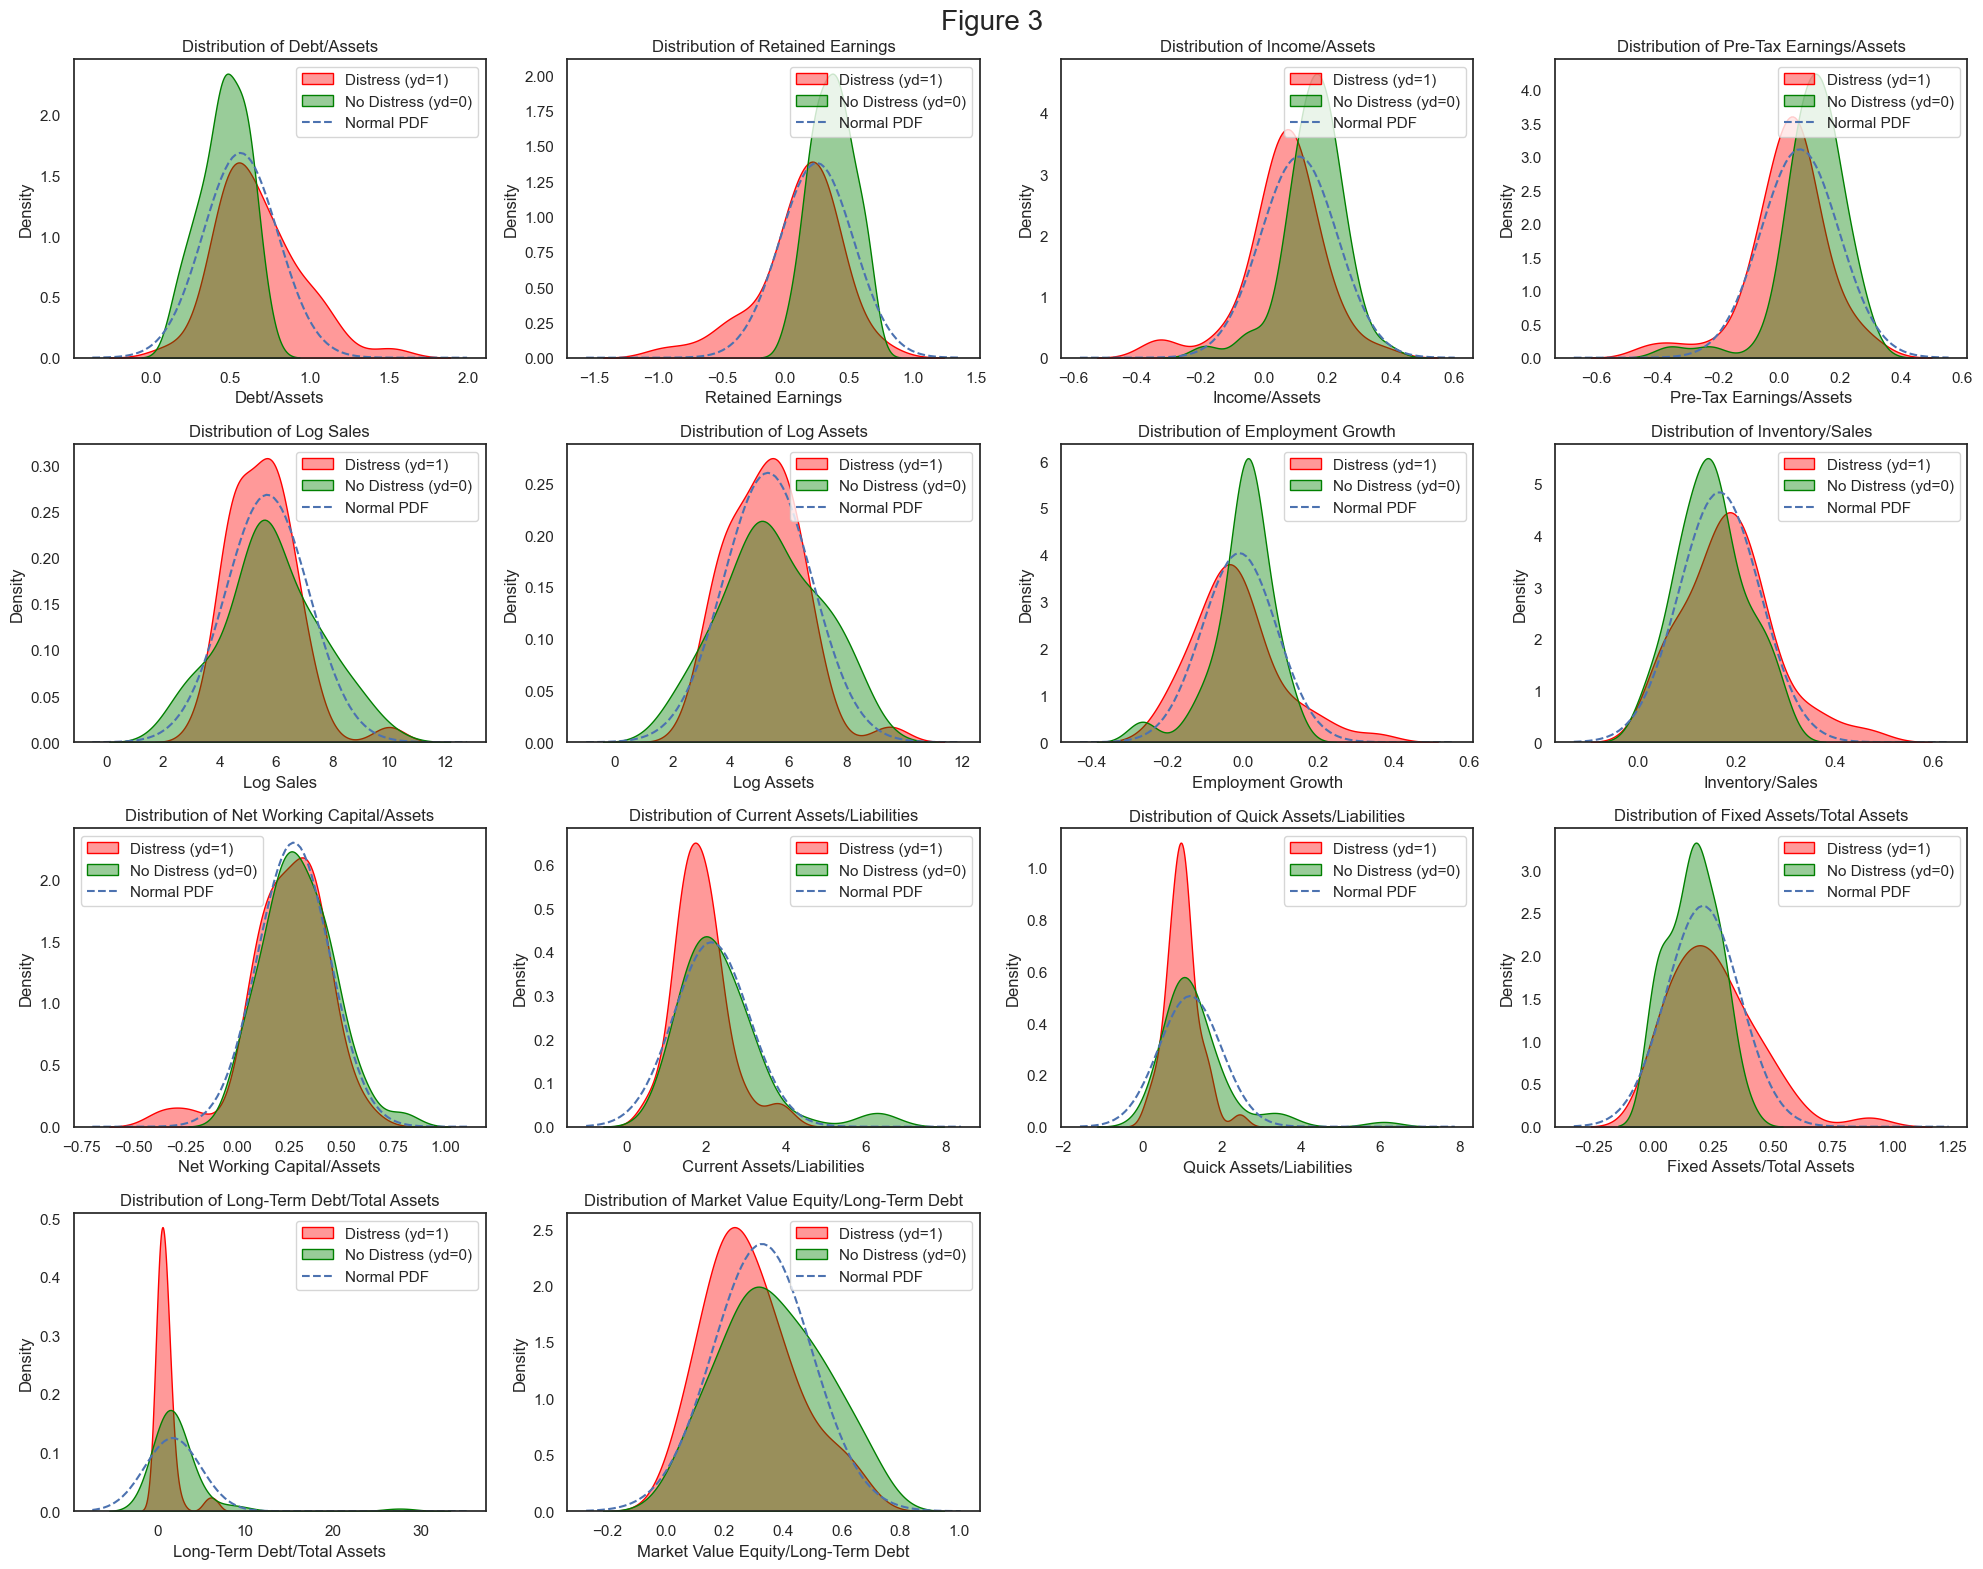

In [95]:
# Data Plotting (variable distribution with respect to the theoretical normal) comparing firms in financial distress (yd=1) with firms out of default risk (yd=0)
# We are back at using the full train dataset, but divided in sub-groups based on financial distress performance 
df_train_distress = df_train[df_train["Financial Distress"] == 1]
df_train_nondistress = df_train[df_train["Financial Distress"] == 0]

# General Layout (column and rows enumeration, figure's size, sub_plot)
num_vars = len(df_train.columns)
cols = 4
rows = (num_vars + cols - 1) // cols
fig, sub_plot = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
sub_plot = sub_plot.flatten()

# Iteration per each variable in X_train (var_i=location of the variable based on index, col_name = variable name)
for var_i, col_name in enumerate(X_train.columns):
    data_distress = df_train_distress[col_name].dropna()
    data_nondistress = df_train_nondistress[col_name].dropna()
# KDE for financial distress
    sns.kdeplot(data_distress, ax=sub_plot[var_i], fill=True, alpha=0.4, color="red", label="Distress (yd=1)")
# KDE for non-distress
    sns.kdeplot(data_nondistress, ax=sub_plot[var_i], fill=True, alpha=0.4, color="green", label="No Distress (yd=0)")

# Normal distribution curve for comparison
    data = X_train[col_name].dropna()
    mu, std = data.mean(), data.std()
    xmin, xmax = sub_plot[var_i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    sub_plot[var_i].plot(x, p, "b--", label="Normal PDF")

    sub_plot[var_i].set_title(f"Distribution of {col_name}")
    sub_plot[var_i].legend()

# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
for j in range(var_i + 1, len(sub_plot)):
    fig.delaxes(sub_plot[j])

plt.suptitle("Figure 3", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 3:** <br>
<br> In this section we move the analysis forward by adding another discriminant to segmentate the train sample in 2 sub-clusters, based on whether the company is in **financial distress** (*yd=1*, red curve) or **otherwise** (*yd=0*, green curve). We do this in order to spot intra-sample discrepancies among the two clusters in the degree of separation or overlap relative to the reference Normal PDF. The binary dependent variable *yd* for firm's Financial Distress is expressed as follows:

$$
y_{d,i} =
\begin{cases}
1, & \text{if Finacial Distress}_i \text{ is true} \\
0, & \text{otherwise}
\end{cases}
$$

Overall, the **non-distressed cluster** (*green*) exhibits tighter, more symmetric distributions which gravitate in proximity of the sample mean, whose economic meaning might be reflected by more stable balance-sheet and income-statement structures. In contrast, **distressed firms** (red) show heavier tails, higher dispersion, and visible skewness, suggesting greater variability and financial imbalance.

Taken together, these patterns reveal that financially distressed firms tend to be more frequently associated with distributional deformation, i.e., larger variance, non-normality, and heavier tails particularly in **leverage**, **profitability**, and **liquidity** dimensions.

In [112]:
# Descriptive Statistics for Financial Distress Firms 
df_train_nondistress.describe()

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
count,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,46.000000,47.000000,48.000000
mean,0.0,0.460608,0.369628,0.156786,0.107330,5.834636,5.418593,0.000158,0.148874,0.293839,2.368610,1.381770,0.165783,2.480729,0.365672
std,0.0,0.149884,0.166109,0.095256,0.111037,1.704057,1.705871,0.081122,0.069010,0.166363,1.093792,0.987178,0.104948,4.138296,0.174090
min,0.0,0.145539,0.036947,-0.184475,-0.356679,2.443132,1.968870,-0.273040,0.016330,-0.007380,0.937172,0.221698,0.000000,0.265216,0.027201
25%,0.0,0.359211,0.243569,0.113238,0.058989,5.050032,4.429123,-0.028393,0.094954,0.183187,1.697610,0.901278,0.084490,0.928405,0.237015
50%,0.0,0.462541,0.380454,0.164526,0.125693,5.696278,5.274143,0.013356,0.148161,0.282609,2.173679,1.119765,0.174475,1.407699,0.366377
75%,0.0,0.589707,0.486708,0.212908,0.169990,7.227277,6.644560,0.040671,0.191108,0.397015,2.839450,1.623884,0.251908,2.338318,0.489388
max,0.0,0.728071,0.672930,0.382154,0.284486,9.816214,8.800619,0.134855,0.285599,0.793606,6.452848,6.093447,0.394493,27.604182,0.708496


In [ ]:
# Descriptive Statistics for Financial Distress Firms  
df_train_distress.describe()

,Financial Distress,Debt/Assets,Retained Earnings,Income/Assets,Pre-Tax Earnings/Assets,Log Sales,Log Assets,Employment Growth,Inventory/Sales,Net Working Capital/Assets,Current Assets/Liabilities,Quick Assets/Liabilities,Fixed Assets/Total Assets,Long-Term Debt/Total Assets,Market Value Equity/Long-Term Debt
count,43.0,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.0,0.676933,0.107836,0.061007,0.024271,5.523381,5.154770,-0.018208,0.184391,0.244951,1.876892,1.009129,0.252763,0.944646,0.287854
std,0.0,0.263775,0.333972,0.128416,0.133340,1.198947,1.317873,0.115695,0.092685,0.180154,0.667421,0.415060,0.184816,1.272550,0.153581
min,1.0,0.108258,-0.958997,-0.342578,-0.427457,3.399509,2.760355,-0.221629,0.034779,-0.362462,0.536236,0.178009,0.000279,0.057734,0.031970
25%,1.0,0.495310,0.003530,0.012888,-0.028740,4.548169,4.198807,-0.076886,0.134320,0.138334,1.438063,0.769895,0.135358,0.252883,0.184884
50%,1.0,0.614653,0.170662,0.070479,0.040687,5.538164,5.101276,-0.030878,0.178018,0.243164,1.841621,1.026836,0.245450,0.617635,0.276766
75%,1.0,0.836259,0.318061,0.115207,0.085945,6.102644,5.999711,0.017232,0.231393,0.355696,2.163271,1.126269,0.355371,1.015631,0.381224
max,1.0,1.512991,0.772500,0.366768,0.310211,10.009634,9.502530,0.352868,0.466175,0.612242,3.976751,2.456635,0.902017,6.555244,0.648762


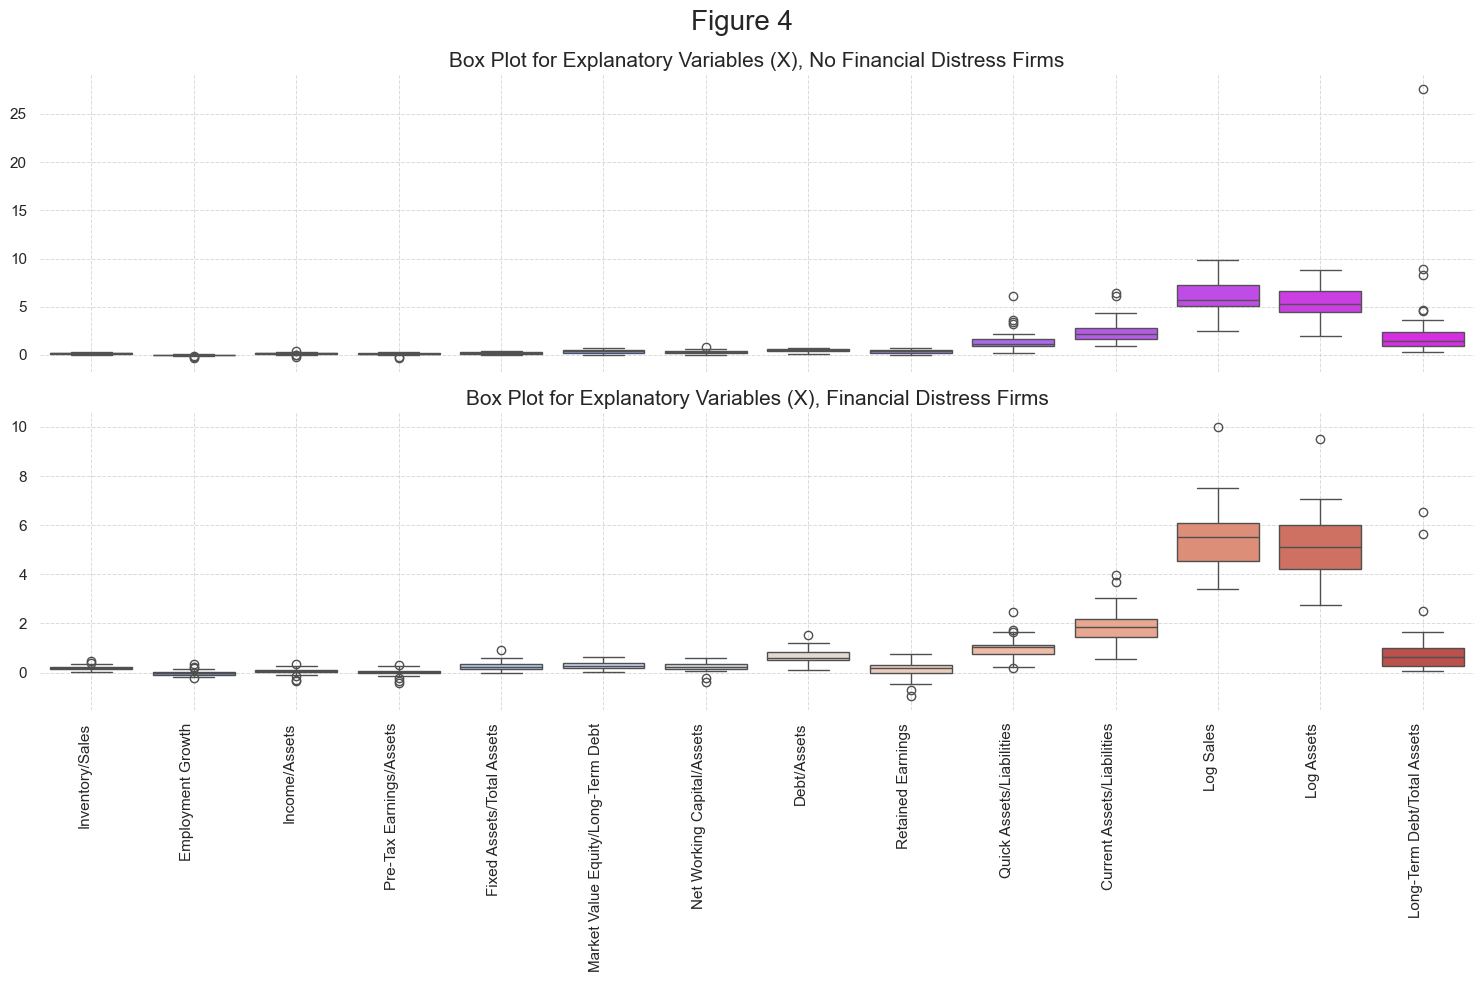

In [ ]:
# Data Plotting (box-plot)

# General Layout (column and rows enumeration, figure's size, sub_plot)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Sorting variables by std (so that logs variable move to the right-hand side, for better readibility)
std_values = df_train.std()
sorted_X_var = list(std_values.sort_values(ascending=True).index)

# List of explanatory variables to plot from the general train dataset df_train
# We include all independent variables, but we need to rule out yd first
X = [col for col in sorted_X_var if col != "Financial Distress"]

# Boxplot for non-Financial Distress firms
sns.boxplot(data=df_train_nondistress[X], ax=axes[0], palette="cool")
axes[0].set_title("Box Plot for Explanatory Variables (X), No Financial Distress Firms", fontsize = 15)
axes[0].set_xticklabels(X, rotation=90, ha="right")

# Deactivate the visibility of ticks in the upper sub-plot, so that we can gain more space for the graph 
labels = axes[0].set_xticklabels(X, rotation=90, ha="right")
for label in labels:
    label.set_visible(False)

# Boxplot for Financial Distress firms
sns.boxplot(data=df_train_distress[X], ax=axes[1], palette="coolwarm")
axes[1].set_title("Box Plot for Explanatory Variables (X), Financial Distress Firms", fontsize = 15)
axes[1].set_xticklabels(X, rotation=90, ha="right", )

# Add grid and remove the frame (spines) for each plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Figure 4", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 4:** <br>
<br> Coherent to the sample split we just discussed, Figure 4 presents comparative box plots for the explanatory variables (X) across the 2 sub-clusters: non-distressed firms (upper panel) and financially distressed firms (lower panel). Each plot summarizes the distribution of key financial ratios and balance sheet indicators, highlighting differences in central tendency, dispersion, and outlier structure. Moreover, unlike the usual plotting order, regressors are here sorted and displayed on **acsending scale** according to their respective std. This procedure is meant to highlight a critical aspect of this first plotting draft, characterized by high-variability variables located in the righ-hand side region of each panel, which tend to strech the **y axis scale** so sharply that it affects **redability** of other variables' box-plot features. As earlier noted during the analysis of extreme observations, it is particularly relevant the contribution of one of Long-Term Debt/Total Assets' values at roughly **27**, clashing with the average upper bound at 1 of several ratios. 

The defects in readability of this box-plot representation allow us to only investigate variables in the high-variability region, while re-scaled panels will be analysed in the following section for the remaining variables. Overall, the distributions exhibit substantial heterogeneity across variables and between groups. Non-distressed firms display negligible higher medians (**5.70 vs 5.54 & 5.27 vs 5.10**) and wider interquartile ranges (**2.17 vs 1.56 & 2.21 vs 1.80**) for size-related variables such as **Log Sales** and **Log Assets**, reflecting greater firm-size heterogeneity. Conversely, distressed firms exhibit more compact distributions, suggesting financial homogeneity among smaller, financially weaker entities. However, by looking at descriptive statistics some might reject the null hypothesis of firms' size homogeneity, as both variables boast significally intra-groups differences in std values, **1.70** (nfd) against **1.20** (fd) for Log Sales and **1.71** against **1.32** for Log Assets. In contrast, leverage indicators (**Debt/Assets**, **Long-Term Debt/Total Assets**) are generally higher, suggesting greater reliance on debt financing as financial conditions deteriorate.

The presence of outliers across most variables, particularly in the non-distressed group, reflects the structural and sectoral diversity of firms. The hypothesis that financial distress is associated with lower profitability, reduced liquidity, higher leverage, and smaller firm size is further corroborated by leverage indicators (**Debt/Assets**, **Long-Term Debt/Total Assets**) exhibiting significantly higher mean and median (excluding outliers), and suggesting greater reliance on debt financing as financial conditions deteriorate. 

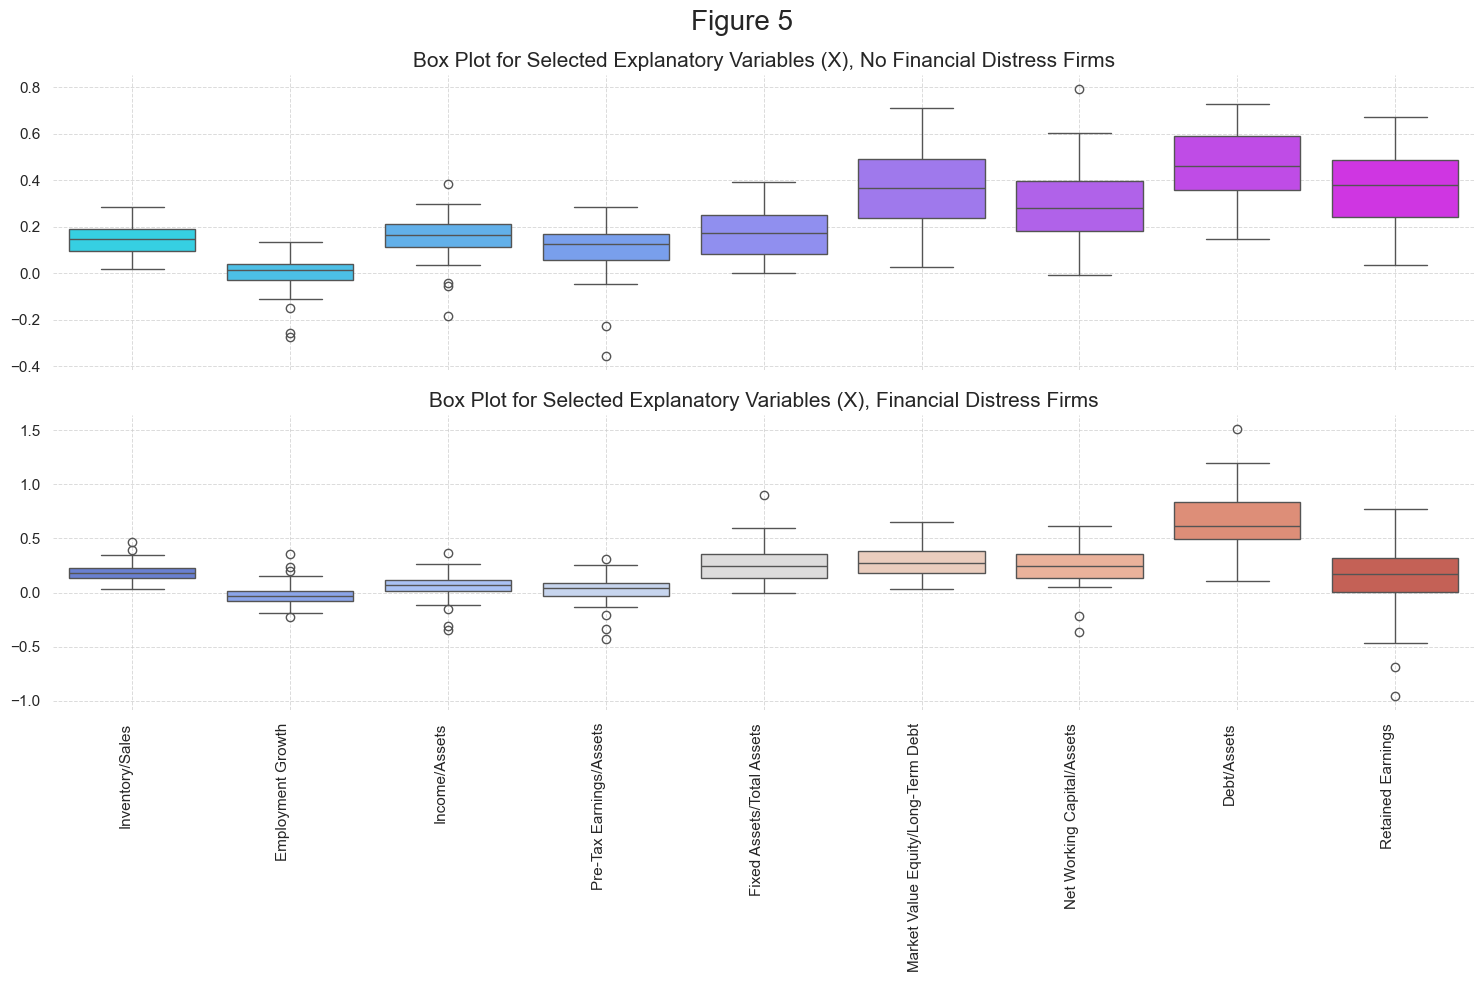

In [97]:
# Data Plotting (box-plot) exluding high-range variables (Log Sales, Log Assets, Long-Term Debt/Total Assets)
# General Layout (column and rows enumeration, figure's size, sub_plot)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Sorting variables by std (so that logs variable move to the right-hand side, for better readibility)
std_values = df_train.std()
sorted_X_var = list(std_values.sort_values(ascending=True).index)

# List of explanatory variables to plot from the general train dataset df_train
# We include all independent variables, but we need to rule out yd first
X = [col for col in sorted_X_var if col not in ["Financial Distress", "Log Sales", "Log Assets", "Long-Term Debt/Total Assets", "Current Assets/Liabilities", "Quick Assets/Liabilities"]]

# Boxplot for  non-Financial Distress firms
sns.boxplot(data=df_train_nondistress[X], ax=axes[0], palette="cool")
axes[0].set_title("Box Plot for Selected Explanatory Variables (X), No Financial Distress Firms", fontsize = 15)
axes[0].set_xticklabels(X, rotation=90, ha="right")
# Deactivate the visibility of ticks in the upper sub-plot, so that we can gain more space for the graph 
labels = axes[0].set_xticklabels(X, rotation=90, ha="right")
for label in labels:
    label.set_visible(False)

# Boxplot for Financial Distress firms
sns.boxplot(data=df_train_distress[X], ax=axes[1], palette="coolwarm")
axes[1].set_title("Box Plot for Selected Explanatory Variables (X), Financial Distress Firms", fontsize = 15)
axes[1].set_xticklabels(X, rotation=90, ha="right", )

# Add grid and remove the frame (spines) for each plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Figure 5", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 5:** <br>
<br> Similarly to what earlier studied, the graph here displays a reduced number of regressors for each panel by ruling out those variables exhibiting higher std and outliers, in order to rescale the y axis for better readibility. 

- **Non-distressed firms** sample exhibits notably higher medians for variables such as Market Value Equity/Long-Term Debt (**0.37 vs 0.28**) and Retained Earnings (**0.38 vs 0.17**), along with broader interquartile ranges, suggesting stronger capitalization, profitability, and financial flexibility. 
- **Financially distressed firms** show instead substantially lower medians and more dispersed distributions for **profitability-related metrics**. For instance, looking at Income/Assets ratio, financially distressed firms exhibit on average, ratios approximately 62% smaller if compared with *healthy* (non financially distressed firms) companies, suggesting lower capital attractiveness and profitability. A similar trend is also evident in Pre-Tax Earnings/Assets, where financially distressed firms show a median ratio of 0.04 against the 0.13 performed by their respective counterpart. In general, this sub-group shows evidence of profitabilty-related metrics often clustering near or below zero, an indication of operating losses and eroded capital bases. Alligned to what discussed in the last chapter. 

These patterns align with extant research on corporate failure prediction: profitability, liquidity, leverage, retained earnings, and solvency ratios are consistently identified as leading indicators of distress risk. For instance, *Altman (1968)* demonstrated that combining these financial ratios into a multivariate discriminant model, **the Z-score**, effectively predicts the probability of bankruptcy. In his study, Altman defines the Z-Score as follows, identifying 3 thresholds of firm's financial distress (Safe zone, Grey Zone, Distress Zone):

$$
AltmanZ = 1.2 \times A + 1.4 \times B + 3.3 \times C + 0.6 \times D + 1.0 \times E
$$

Where:

$$
A = \frac{\text{Working Capital}}{\text{Total Assets}}, \quad
B = \frac{\text{Retained Earnings}}{\text{Total Assets}}, \quad
C = \frac{\text{EBIT}}{\text{Total Assets}}, \quad
D = \frac{\text{Market Value of Equity}}{\text{Total Liabilities}}, \quad
E = \frac{\text{Sales}}{\text{Total Assets}}
$$

<div style="display: flex; align-items: center; justify-content: center; gap: 50px;">
  <div>
    <p><strong>Interpretation (for manufacturing firms):</strong></p>
    <ul>
      <li>Z > 2.99 → Safe Zone</li>
      <li>1.81 < Z < 2.99 → Grey Zone</li>
      <li>Z < 1.81 → Distress Zone</li>
    </ul>
  </div>
  <div>
    <img src="Images/altman-z.png" alt="Graph" width="300"/>
  </div>
</div>

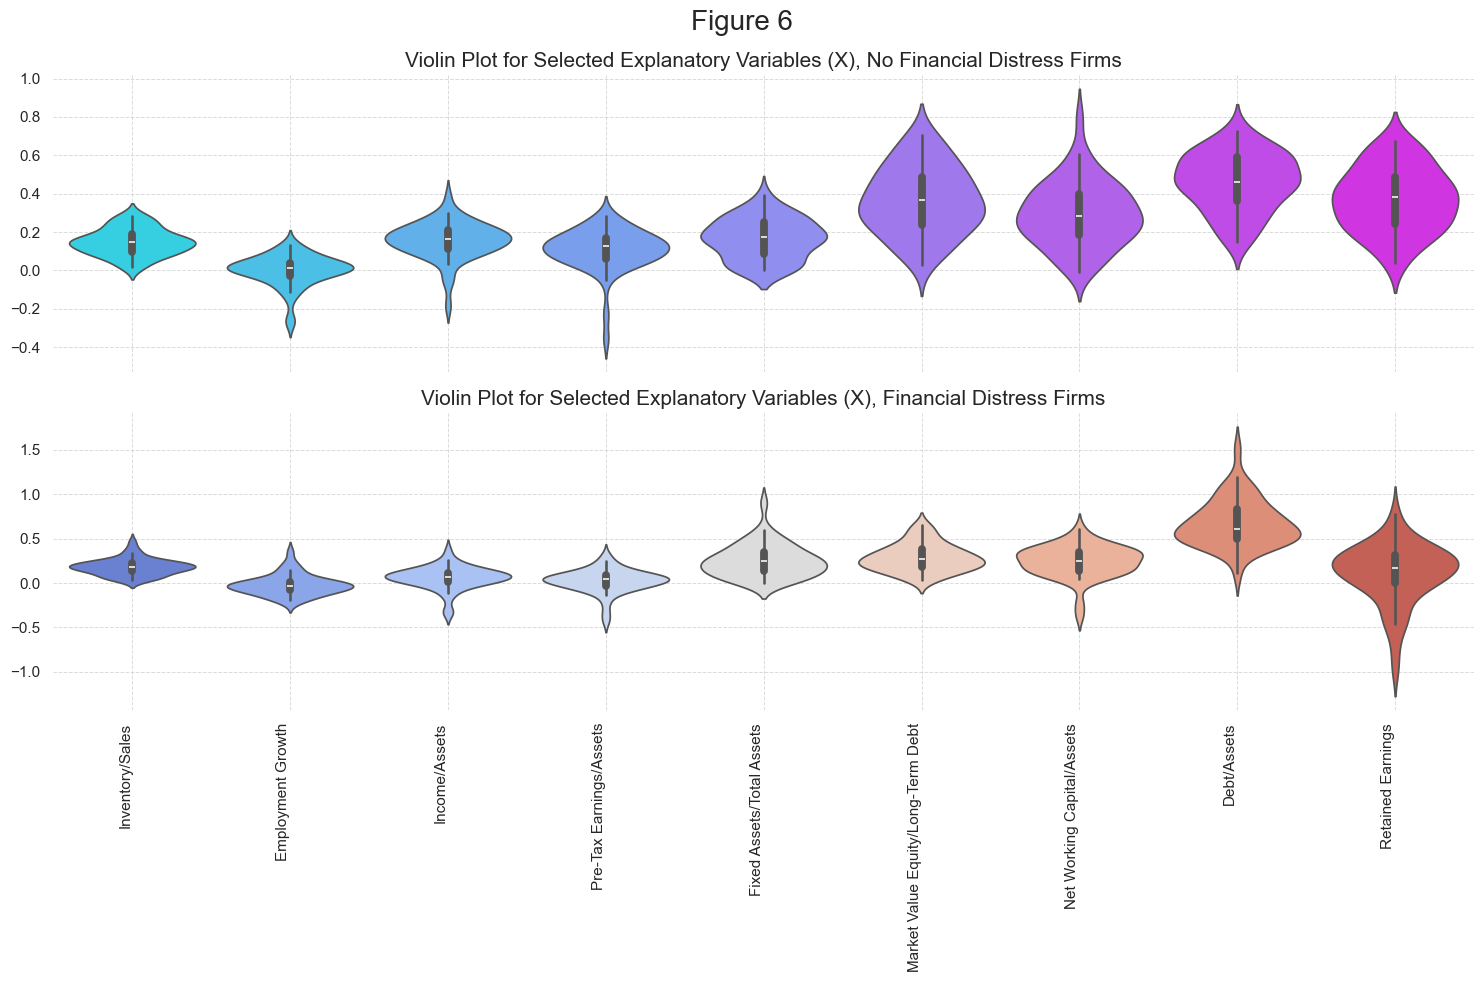

In [98]:
# Data Plotting (Violin-plot) exluding high-range variables (Log Sales, Log Assets, Long-Term Debt/Total Assets)
# General Layout (column and rows enumeration, figure's size, sub_plot)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Sorting variables by std (so that logs variable move to the right-hand side, for better readibility)
std_values = df_train.std()
sorted_X_var = list(std_values.sort_values(ascending=True).index)

# List of explanatory variables to plot from the general train dataset df_train
# We include all independent variables, but we need to rule out yd first
X = [col for col in sorted_X_var if col not in ["Financial Distress", "Log Sales", "Log Assets", "Long-Term Debt/Total Assets", "Current Assets/Liabilities", "Quick Assets/Liabilities"]]

# Violin-plot for No Financial Distress firms
sns.violinplot(data=df_train_nondistress[X], ax=axes[0], palette="cool")
axes[0].set_title("Violin Plot for Selected Explanatory Variables (X), No Financial Distress Firms", fontsize = 15)
axes[0].set_xticklabels(X, rotation=90, ha="right")
# Deactivate the visibility of ticks in the upper sub-plot, so that we can gain more space for the graph 
labels = axes[0].set_xticklabels(X, rotation=90, ha="right")
for label in labels:
    label.set_visible(False)

# Violin-plot for Financial Distress firms
sns.violinplot(data=df_train_distress[X], ax=axes[1], palette="coolwarm")
axes[1].set_title("Violin Plot for Selected Explanatory Variables (X), Financial Distress Firms", fontsize = 15)
axes[1].set_xticklabels(X, rotation=90, ha="right", )

# Background grid and frame (spines) removal for each plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.7)

plt.suptitle("Figure 6", fontsize = 20)
plt.tight_layout()
plt.show()

**FIGURE 6:** <br>
<br> For further clarity, this figure presents **violin plots** comparing the distributions of selected explanatory financial variables for firms with and without financial distress. Despite not largely adopted, violin plots uniquely provide both the density distribution and summary statistics of each variable, highlighting not just quartiles and outliers but also the overall shape and multimodality of the data.

Each "violin" illustrates the probability density of the data along the y-axis, allowing for visual assessment of how values cluster, spread, and deviate for each variable. The width at each y-value corresponds to the density; wider sections indicate higher concentration of observations at that value, while narrower sections reflect sparsity. Inside each violin, a box plot is overlaid, showing the median as a central white dot, and the interquartile range as a thick black bar, with thinner lines denoting confidence intervals or possible outliers. Overall, the **added value** value of this plotting option is the capability of aggregating together descriptive statistics and graphical representations of distributions in one single panel, **avoiding shifting** continuously from one graph to the other. If compared to standard box plots like the ones just plotted, violin plots reveal more subtle features such as bimodality, skewness, and outlier clusters, which are particularly pronounced in our sample.

<p align="center">
    <img src="Images/violin_plot.png" alt="Graph" width="300"/>
</p>

In terms of analysis of distributions, the earlier drafted conclusions still holds. For firms not financially challenged, violins generally show taller and more symmetrically distributed densities, indicating more consistent performance and less extreme variation in key ratios. While, financial distress firms have violins that are shorter, skewed, or multi-peaked (bimodality), especially for retained earnings and debt/assets, revealing greater variability, fatter tails, and concentrations of negative outcomes that are less apparent in our first conventional box plots.


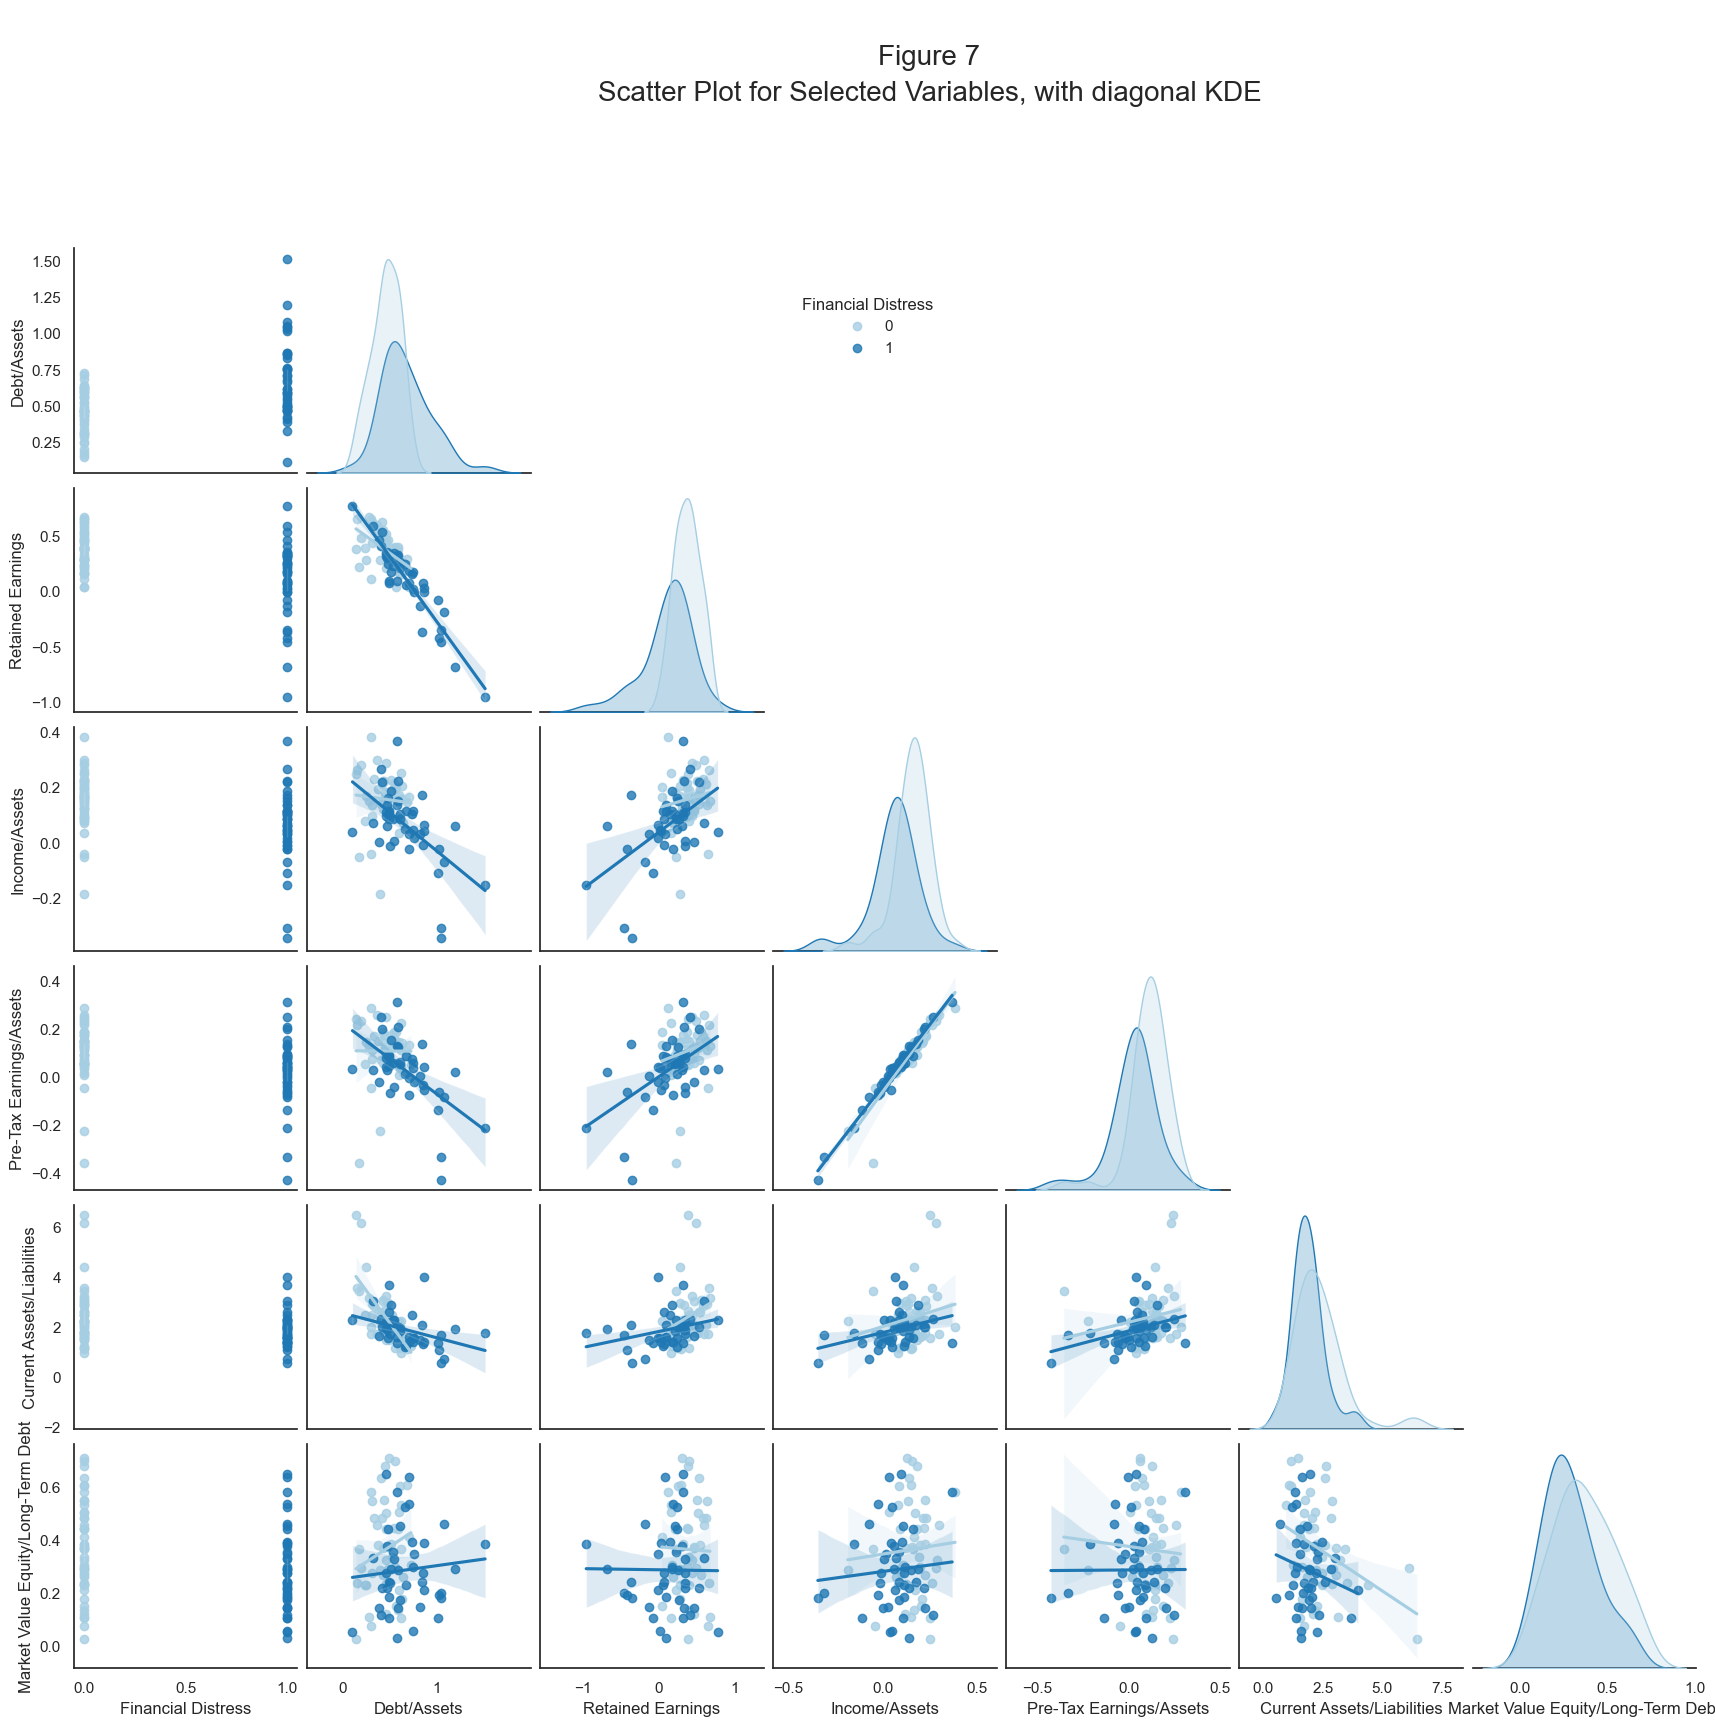

In [99]:
# Data Plotting (Scatter-plot & diagonal KDE), selected variables relative distribution per subgroup (No Financial Distress & Financial Distress firms)
# Filtering of target variables (explanatory + dependent)
Xy = [col for col in df_train.columns if col not in 
        ["Inventory/Sales", 
         "Net Working Capital/Assets", 
         "Long-Term Debt/Total Assets", 
         "Log Sales", 
         "Log Assets", 
         "Fixed Assets/Total Assets", 
         "Quick Assets/Liabilities", 
         "Employment Growth"]]

# Scatter-plot + Diagonal KDE (g)
# No need to deploy separate datasets for the 2 sub-groups of firms, as sns.pairplot has already an integrated function (hue) to split the sample
# "reg" in kind offers much more insights than only "scatter", by adding the respective trend curves and std range
g = sns.pairplot(df_train, 
                 hue="Financial Distress", 
                 hue_order=[0, 1], 
                 vars=Xy, 
                 kind="reg", 
                 diag_kind="kde", 
                 palette="Paired", 
                 corner=True)

# Deletion of unused subplots (we have less variables than available slots for subplots on the page)
g.fig.axes[0].set_visible(False) 

# Figure elements positioning adjustments
g._legend.set(bbox_to_anchor=(0.5, 0.8), transform=g.fig.transFigure)
g._legend._ncol = 2
g.fig.subplots_adjust(top=0.99)

g.fig.suptitle("Figure 7\nScatter Plot for Selected Variables, with diagonal KDE", 
               fontsize=20, y=0.97, ha="center", linespacing=1.5)
plt.show()

**FIGURE 7:** <br>
<br> In previous analysis we have addressed descriptive statistics and distribution features for each variable **individually**. In this chapter, we add an additional layer of complexity by investigating how selected regressors interact with the dependent variable *yd*, as well as with each other. Moreover, we are also interested to verify whether there is evidence of different intra-group correlations terms among variables between **financial distress firms** (dark blue) and **non-distressed firms** (light blue). The presented scatter plot matrix examine interrelations among critical financial distress predictors. The plotted variables have been selected among the wide range of available ratios in order to guarantee the readibility of the matrix, as well as the informative scope of the graph, since including an excess of regressors belonging to the same group of metrics, and hence highly correlated, would have been of weakly explicative. Thus, we included a range of representative variables to plot the interaction dynamics between **profitability**, **liquidity**, **leverage** and **retained earnings** metrics (see **Altman, 1968**). The matrix (pairplot) plots the kernel density estimates (KDE) along the diagonals for each variable and data clouds with trend per group in the intersection between variables.  

- **Debt/Assets and Financial Distress**: A strong positive relationship is observed between the debt-to-assets ratio and financial distress, with the data cloud of dark blue dots alligned on *yd=1* and shifted upwards with respect to the *healthy* counterpart, suggesting higher Debt/Assets ratios. As expected, firms with higher leverage are more likely to encounter financial distress, consistent with *Altman's Z-Score*. 

- **Retained Earnings and Income/Assets versus Distress**: In contrast to leverage metrics, retained earnings (as a proportion of assets) and income-to-assets both show notable negative associations with financial distress. Distressed firms cluster at lower retained earnings and income levels, implying persistent underperformance or historical losses, which erode equity cushions and increase vulnerability to external shocks. At the same time, the bivariate correlation between **reta** and **opita** ratios appears to be rather positively sloped, especially for financially distressed firms, despite wider intra-group variability.

- **Income/Assets and Pre-tax Earnings/Assets**: The most pronounced positive correlation among explanatory variables is observed between the income-to-assets ratio and the pre-tax earnings-to-assets ratio, as shown by the near-diagonal scatter pattern. The observed trend is also extreemly stable among the two sample clusters. This indicates that profit-based metrics are mutually reinforcing predictors in distress models. However, their collinearity suggests redundancy and incapacity of capturing additional *yd* variability if both are used in multivariate regressions. This risk of potential loss in model accuracy due to regressors multicollinearity is coherent with our initial constraint of fewer representative variables per metrics category. 

- **Current Assets/Liabilities and Market Value Equity/Long-term Debt**:
The Current Assets/Liabilities displays mild negative correlation with distress; low liquidity undermines firms' short-term solvency, increasing default likelihood. Market value equity relative to long-term debt shows a modest, perhaps non-significant, relationship with distress. This aligns with findings that market-based ratios provide early warning but are often secondary to accrual accounting metrics in short-term distress prediction. In other words, we corroborate the refusal for the urban theory of "*too big to fail*", as market indicators are potentially helpful in highlighting firm-level criticalities, but also often not enough. Market performances are subjected to speculations, and negative allarms frequently offset by profit hunts, leading to firms' **accounting perception biases**.  

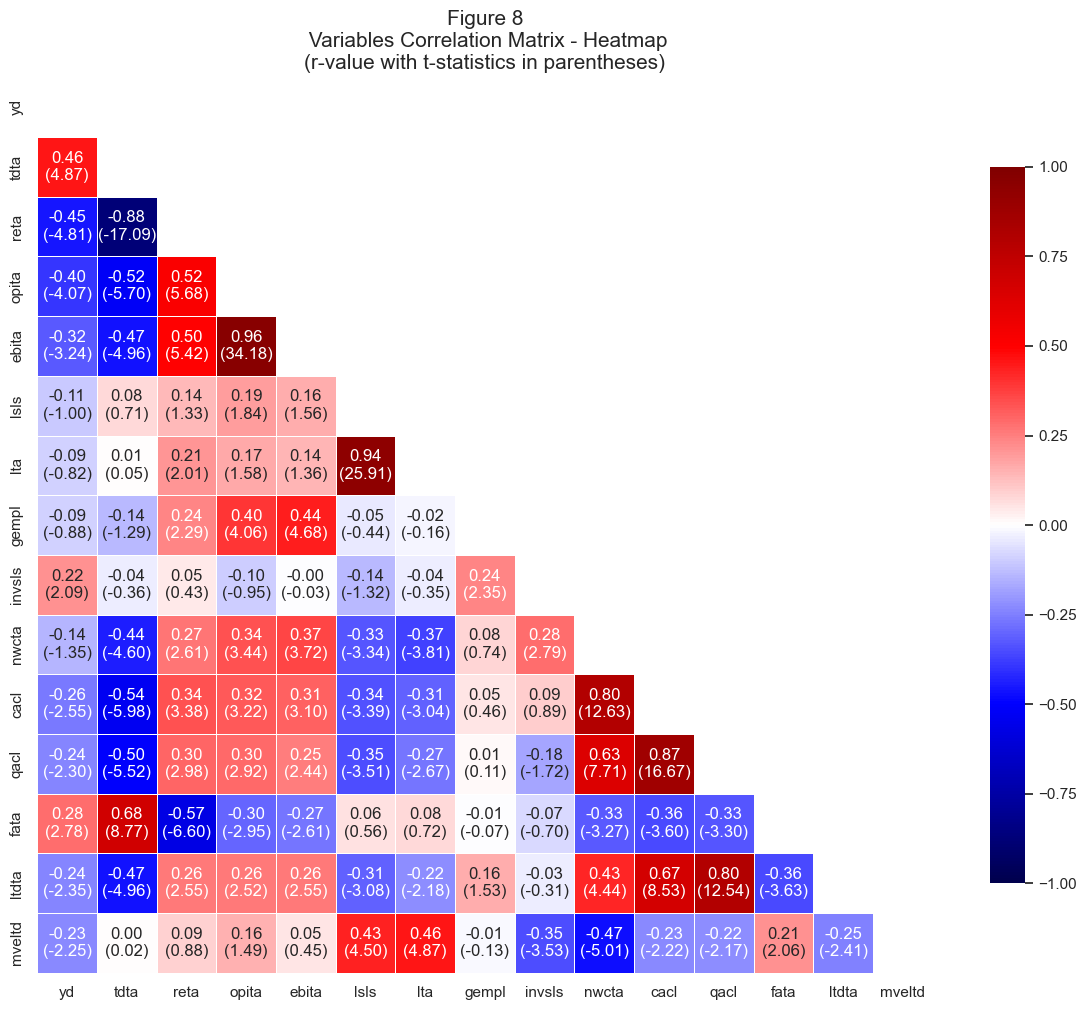

In [100]:
# Data Plotting (Correlation Heatmap)
# Variable renaming (inverted variables dictionary from full names to acronyms)
df_train_short = df_train.copy()
df_train_short.rename(columns=inverted_variables, inplace=True)

# Correlation matrix
corr_matrix = df_train_short.corr()
# Sample size
n = df_train.shape[0]

# t-statistics derived from correlation values
with np.errstate(divide="ignore", invalid="ignore"):
    t_stat_matrix = corr_matrix * np.sqrt((n - 2) / (1 - corr_matrix**2))
    t_stat_matrix = t_stat_matrix.round(2)

# For each cell, we want to have both the correlation index, as well as the just computed t-statistics
annot_matrix = corr_matrix.copy().astype(str)

for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
# We only want to keep the lower triangle and diagonal of the full correlation matrix
        if i >= j: 
            r = corr_matrix.iloc[i, j]
            t = t_stat_matrix.iloc[i, j]
            annot_matrix.iloc[i, j] = f"{r:.2f}\n({t:.2f})"
        else:
            annot_matrix.iloc[i, j] = ""

# We manually hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heat-map plot
# General Layout (figure's size and style)
plt.figure(figsize=(12, 10))
sns.set(style="white")

sns.heatmap(corr_matrix,
            mask=mask,
            annot=annot_matrix,
            fmt="",               
            cmap="seismic",          
            vmin=-1, vmax=1,       
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})


plt.title("Figure 8\n Variables Correlation Matrix - Heatmap\n(r-value with t-statistics in parentheses)", 
          fontsize=15)
plt.tight_layout()
plt.show()

**FIGURE 8:** 

Complementary to the scatter-plot matrix is the heatmap above visualizing the pairwise **Pearson correlation coefficients** among with the respective **t-statistics** for statistical significance. This dual representation provides insights into both the **direction** and **strength** of linear relationships between variables. The color scaling is structured to display a proportionally warmer tone of red or darken tone of blue depending on the direction and intensity of the correlation. Shades of red are associated with positive correlations, neutral or white coloring displays weak correlations and blue tones are linked with negative interactions. 

---

**Pearson Correlation Coefficient**

The Pearson correlation coefficient quantifies the linear association between two variables (*X*) and (*Y*). Hence, the coefficient value is uncorrelated and independent from the number *n* of observetaions, composing the sample, which instead affects the *t-statistics*. The correlation coefficient can be computed as follows:

$$
r = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}
{\sqrt{\sum_{i=1}^{n}(X_i - \bar{X})^2 \sum_{i=1}^{n}(Y_i - \bar{Y})^2}}
$$

where:
- *Xi*, *Yi* are paired observations,
- *X*, *Y* denote the sample means,
- *n* is the number of observations.

The coefficient *r* lies between -1 and +1:
- *r > 0* : positive linear relationship (*red*),  
- *r < 0* : negative linear relationship (*blue*),  
- *| r |* close to 1 indicates a strong relationship, while values near 0 suggest weak or no linear association (*color tone*).

---

**t-Statistic for Testing Significance**

To test the null hypothesis *H0: r = 0* (no correlation), the *t*-statistic is deployed:

$$
t = r \sqrt{\frac{n - 2}{1 - r^2}}
$$

where the degrees of freedom *df = n - 2*. A large absolute *t*-value implies the correlation is **statistically significant**, following a Student’s *t*-distribution.

<div style="display: flex; align-items: center; justify-content: center; gap: 50px;">
  <div>
    <p>We observe that, while r is independent from n, the t-statistic exhibits the number of observations (sample size) at the numerator, suggesting that the function is increasing for the the number of observations (as for the coefficient r). We then expect that the larger the sample, the more statistically significant will be the correlation coefficient. These assumptions are well graphically represented by a funnel plot, showing the number n of observation on the x-axis and the range of variation of r from -1 to 1 on the y-axis. Note that in this example the funnel plot is transposed of 90 degrees, thus showing inverted axis.</p>
  </div>
  <div>
    <img src="Images/funnel_plot.png" alt="Graph" width="300"/>
  </div>
</div>

---
**Correlation Analysis and Implications**

Addresing the **risk of multicollinearity**, where explanatory variables convey overlapping information, causing a loss of model accuracy in capturing *yd* variability, we investigate the correlation, and its statistical significance, among regressors. Beyond multicollinearity diagnosis, this analysis offers a comprehensive overview of the interdependencies among variables, and creates a solid starting-point for the indentification of potential instrumental/control variables for the upcoming modelling chapters. 

- **Highly Positive Correlations (r > 0.80)**
   - *ebita* and *opita* (r ≈ 0.96, t = 34.18): very strong positive association, indicating that earnings-based ratios are closely related.  
   - *lta* and *lsls* (r ≈ 0.94, t = 25.91): potential scale-related or balance sheet structure similarities.
   - *qacl* and *cacl* (r ≈ 0.87, t = 16.67): high coherence between quick and current asset-based liquidity measures.
   - *cacl* and "nwcta* (r ≈ 0.80, t = 12.63): both ratios capture liquidity and operational flexibility, hence their positive co-movement is expected.
   - *qacl* and "ltdta* (r ≈ 0.80, t = 12.54): the positive correlation may seem counter-intuitive, as liquidity and leverage often move inversely.  
     However, in this context, it suggests that firms with strong liquidity buffers also tend to sustain higher long-term debt levels. The t-statistic seems to hold robust to this assumption, but it will be investigated further. 

- **Highly Negative Correlations (r < -0.80):**
   - *reta* and *tdta* (r ≈ -0.88, t = -17.09): the negative correlation indicates that firms with higher retained earnings tend to have lower debt ratios, consistent with the *pecking order* theory of financing. The high value of the t-statistics also confirms the robustness of the theoretical model.  

With regards to the dependent variable, *yd* exhibits **moderate positive correlation** a quite heterogenous pattern of correlation across variables and groups of metrics. In terms of leverage, financial distress shows a moderate positive correlation with *tdta* (r = 0.46, t = 4.87), suggesting that higher debt ratios are associated with increases in the dependent outcome—potentially reflecting leverage-related effects on firm performance or valuation. Among positive correlated variables, *tdta* boasts the highest coefficient value with *yd*, while *fata* and *invsls* stop at only 0.22 and 0.28 respectively, with absolute t-stats still above 2. In contrast, variables belonging to profitability metrics or retained earnings, such as *reta* (r ≈ -0.45, t = -4.81), *opta* (r ≈ -0.40, t = -4.07), and *ebita* (r ≈ -0.32, t = -3.24) show significant **negative correlations** with *yd*, implying that stronger profitability or retained earnings ratios are linked to lower *yd* levels. This pattern aligns with conventional corporate finance behavior: firms with greater internal funds rely less on external financing.

In [101]:
# Normality Test (Jarque Bera Test) for AGGREGATE data, NO FINANCIAL DISTRESS firms data, FINANCIAL DISTRESS firms data
# H0: Data follow a normal distribution 
# The larger the JB stat, the more the distribution deviates from the normal. The smaller the p-value the greater is the confidence of statistically significant results.
# Default empty dataset, with 3 columns per each cluster of observations
df_train_jarque_bera = pd.DataFrame(columns=["AGGREGATE - Jarque Bera Stat", "AGGREGATE - p-value", "AGGREGATE - Statistical Significance",
                                             "NO DISTRESS - Jarque Bera Stat", "NO DISTRESS - p-value", "NO DISTRESS - Statistical Significance",
                                             "DISTRESS - Jarque Bera Stat", "DISTRESS - p-value", "DISTRESS - Statistical Significance" ])

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable, for each sub-cluster, to extract its respective JB stat and p-value, to then concatenate each single test results set in an aggregate dataset 
for i in target_variables:

# Aggregate
    jb_stat = stats.jarque_bera(df_train[i])[0]
    jb_pvalue = stats.jarque_bera(df_train[i])[1]
# NO Financial Distress
    nondistress_jb_stat = stats.jarque_bera(df_train_nondistress[i])[0]
    nondistress_jb_pvalue = stats.jarque_bera(df_train_nondistress[i])[1]
# Financial Distress
    distress_jb_stat = stats.jarque_bera(df_train_distress[i])[0]
    distress_jb_pvalue = stats.jarque_bera(df_train_distress[i])[1]


# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's JB-stat
    jb_significance = significance_stars(jb_pvalue)
    nondistress_jb_significance = significance_stars(nondistress_jb_pvalue)
    distress_jb_significance = significance_stars(distress_jb_pvalue)

    df_train_jarque_bera = pd.concat(
        [df_train_jarque_bera, pd.DataFrame({"AGGREGATE - Jarque Bera Stat": [jb_stat], "AGGREGATE - p-value": [jb_pvalue], "AGGREGATE - Statistical Significance": [jb_significance],
                                             "NO DISTRESS - Jarque Bera Stat": [nondistress_jb_stat], "NO DISTRESS - p-value": [nondistress_jb_pvalue], "NO DISTRESS - Statistical Significance": [nondistress_jb_significance],
                                             "DISTRESS - Jarque Bera Stat": [distress_jb_stat], "DISTRESS - p-value": [distress_jb_pvalue], "DISTRESS - Statistical Significance": [distress_jb_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_jarque_bera.index = target_variables

print("Train Dataset - Jarque Bera Test of Normality for Aggregate and Sub-Cluster Data")
df_train_jarque_bera

Train Dataset - Jarque Bera Test of Normality for Aggregate and Sub-Cluster Data


,AGGREGATE - Jarque Bera Stat,AGGREGATE - p-value,AGGREGATE - Statistical Significance,NO DISTRESS - Jarque Bera Stat,NO DISTRESS - p-value,NO DISTRESS - Statistical Significance,DISTRESS - Jarque Bera Stat,DISTRESS - p-value,DISTRESS - Statistical Significance
Debt/Assets,37.193060,8.387443e-09,***,1.828790,4.007589e-01,,6.919505,3.143754e-02,*
Retained Earnings,75.339112,4.368373e-17,***,1.236212,5.389644e-01,,12.447095,1.982201e-03,**
Income/Assets,42.915093,4.798504e-10,***,21.106657,2.610644e-05,***,17.408268,1.658985e-04,***
Pre-Tax Earnings/Assets,67.437826,2.270190e-15,***,99.889812,2.037994e-22,***,21.403800,2.250214e-05,***
Log Sales,4.334757,1.144773e-01,,0.264182,8.762612e-01,,22.648443,1.207683e-05,***
Log Assets,1.040418,5.943963e-01,,0.963148,6.178101e-01,,4.801741,9.063904e-02,
Employment Growth,13.073772,1.448994e-03,**,33.260964,5.990644e-08,***,9.973004,6.829512e-03,**
Inventory/Sales,11.885658,2.624595e-03,**,0.821284,6.632242e-01,,4.849740,8.848961e-02,
Net Working Capital/Assets,12.933199,1.554503e-03,**,2.195424,3.336336e-01,,15.245015,4.893134e-04,***
Current Assets/Liabilities,228.928451,1.944547e-50,***,77.911606,1.207007e-17,***,12.992647,1.508977e-03,**


**JARQUE-BERA TEST OF NORMALITY:** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [102]:
# Equality of Variance Test (Levene Test) applied on 3 clusters: AGGREGATE data, NO FINANCIAL DISTRESS firms data, FINANCIAL DISTRESS firms data
# H0: All groups have equal variances
# The Levene measures the differences in variance (spread) between groups (the closer to 0 the better, meaning that each group's deviation from the median (center) does not differ a lot from the others. They have more or less the same shift from the center.). The bigger the more likely is the rejection of H0, hence the variances are not equal.
# We center the test on the median of aggregate data, in order to be more robust against the outliers we observed earlier for some variables
# Default empty dataset
df_train_levene = pd.DataFrame(columns=["ALL Levene Stat (groups = Aggregate, NO Financial Distress, Financial Distress)", "ALL p-value", "ALL Statistical Significance", 
                                        "NFD-FD Levene Stat (groups =  NO Financial Distress, Financial Distress)", "NFD-FD p-value", "NFD-FD Statistical Significance"])

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable, for each sub-cluster, to extract its respective Levene stat and p-value, to then concatenate each single test results set in an aggregate dataset 
for i in target_variables:

# ALL (groups = Aggregate, NO Financial Distress, Financial Distress)
    all_levene_stat = levene(df_train[i], df_train_nondistress[i], df_train_distress[i], center="median")[0]
    all_levene_pvalue = levene(df_train[i], df_train_nondistress[i], df_train_distress[i], center="median")[1]

# NFD-FD (groups =  NO Financial Distress, Financial Distress)
    nfdfd_levene_stat = levene(df_train_nondistress[i], df_train_distress[i], center="median")[0]
    nfdfd_levene_pvalue = levene(df_train_nondistress[i], df_train_distress[i], center="median")[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's Levene-stat
    all_levene_significance = significance_stars(all_levene_pvalue)
    nfdfd_levene_significance = significance_stars(nfdfd_levene_pvalue)
    
    df_train_levene = pd.concat(
        [df_train_levene, pd.DataFrame({"ALL Levene Stat (groups = Aggregate, NO Financial Distress, Financial Distress)": [all_levene_stat], "ALL p-value": [all_levene_pvalue], "ALL Statistical Significance": [all_levene_significance],
                                        "NFD-FD Levene Stat (groups =  NO Financial Distress, Financial Distress)": [nfdfd_levene_stat], "NFD-FD p-value": [nfdfd_levene_pvalue], "NFD-FD Statistical Significance": [nfdfd_levene_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_levene.index = target_variables

print("Train Dataset - Levene Test of Equality of Variance (Aggregate, NO Financial Distress, Financial Distress clusters)")
df_train_levene

Train Dataset - Levene Test of Equality of Variance (Aggregate, NO Financial Distress, Financial Distress clusters)


,"ALL Levene Stat (groups = Aggregate, NO Financial Distress, Financial Distress)",ALL p-value,ALL Statistical Significance,"NFD-FD Levene Stat (groups = NO Financial Distress, Financial Distress)",NFD-FD p-value,NFD-FD Statistical Significance
Debt/Assets,3.194066,0.043352,*,7.467590,0.007577,**
Retained Earnings,3.270672,0.040263,*,7.365796,0.007982,**
Income/Assets,1.044412,0.354033,,1.408566,0.238453,
Pre-Tax Earnings/Assets,0.520909,0.594878,,0.681277,0.411354,
Log Sales,1.695079,0.186518,,3.453616,0.066419,
Log Assets,1.366363,0.257680,,2.766754,0.099759,
Employment Growth,2.063401,0.130032,,3.994256,0.048707,*
Inventory/Sales,0.875592,0.418392,,1.710994,0.194225,
Net Working Capital/Assets,0.040692,0.960134,,0.082090,0.775150,
Current Assets/Liabilities,1.333800,0.266080,,2.787402,0.098522,


**LEVENE TEST OF EQUALITY OF VARIANCE:** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [103]:
# Distributional Equivalence Test (Kolomogorv-Smirnov Test) applied on two pairs: NO Financial Distress - Financial Distress and Aggregate - Normal PDF
# H0: The two samples are drawn from the same distribution
# or in case of comparison with normal PDF -> H0: Sample comes from a normal distribution
# The larger the KS stat, the stronger the evidence that the target samples do not come from the same distributions. Or alternatively, in the case of comparison with the theoretical normal, KS again measure the deviation magnitude pf the sample from the normal PDF. 
# Default empty dataset
df_train_ks = pd.DataFrame(columns=["NFD-FD KS Stat (groups =  NO Financial Distress, Financial Distress)", "NFD-FD p-value", "NFD-FD Statistical Significance",
                                    "AGG-NORM KS Stat (groups =  Aggregate, Normal PDF)", "AGG-NORM p-value", "AGG-NORM Statistical Significance"])

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable, for each sub-cluster, to extract its respective KS stat and p-value, to then also compare the distribution with the Normal, as double-check to JB for non-normal distributions
for i in target_variables:

# NFD-FD (groups =  NO Financial Distress, Financial Distress)
    nfdfd_ks_stat = ks_2samp(df_train_nondistress[i], df_train_distress[i])[0]
    nfdfd_ks_pvalue = ks_2samp(df_train_nondistress[i], df_train_distress[i])[1]

# AGG-NORM (groups =  Aggregate, Normal PDF)
    aggnorm_ks_stat = kstest(df_train[i], "norm", args=(df_train[i].mean(), df_train[i].std()))[0]
    aggnorm_ks_pvalue = kstest(df_train[i], "norm", args=(df_train[i].mean(), df_train[i].std()))[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's KS-stat
    nfdfd_ks_significance = significance_stars(nfdfd_ks_pvalue)
    aggnorm_ks_significance = significance_stars(aggnorm_ks_pvalue)
    
    df_train_ks = pd.concat(
        [df_train_ks, pd.DataFrame({"NFD-FD KS Stat (groups =  NO Financial Distress, Financial Distress)": [nfdfd_ks_stat], "NFD-FD p-value": [nfdfd_ks_pvalue], "NFD-FD Statistical Significance": [nfdfd_ks_significance],
                                    "AGG-NORM KS Stat (groups =  Aggregate, Normal PDF)": [aggnorm_ks_stat], "AGG-NORM p-value": [aggnorm_ks_pvalue], "AGG-NORM Statistical Significance": [aggnorm_ks_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_ks.index = target_variables

print("Train Dataset - Kolomogorv-Smirnov Test of Distributional Equivalence (NO Financial Distress - Financial Distress, Aggregate - Normal PDF)")
df_train_ks

Train Dataset - Kolomogorv-Smirnov Test of Distributional Equivalence (NO Financial Distress - Financial Distress, Aggregate - Normal PDF)


,"NFD-FD KS Stat (groups = NO Financial Distress, Financial Distress)",NFD-FD p-value,NFD-FD Statistical Significance,"AGG-NORM KS Stat (groups = Aggregate, Normal PDF)",AGG-NORM p-value,AGG-NORM Statistical Significance
Debt/Assets,0.402616,0.000774,***,0.127135,0.096600,
Retained Earnings,0.446221,0.000127,***,0.130089,0.083901,
Income/Assets,0.496609,0.000012,***,0.096410,0.343953,
Pre-Tax Earnings/Assets,0.418120,0.000426,***,0.137462,0.058187,
Log Sales,0.224322,0.167228,,0.090352,0.422558,
Log Assets,0.219477,0.186320,,0.054607,0.935188,
Employment Growth,0.300872,0.024751,*,0.095063,0.360560,
Inventory/Sales,0.310562,0.018828,*,0.066856,0.785428,
Net Working Capital/Assets,0.147287,0.637040,,0.053385,0.945346,
Current Assets/Liabilities,0.285853,0.037875,*,0.152696,0.025616,*


**KOLOMOGORV-SMIRNOV TEST OF DISTRIBUTIONAL EQUIVALENCE:** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [104]:
# Linear Correlation Test (Pearson r Test) between the dependent variable y ("Financial Distress") and the matrix of explanatory variables X
# H0: no linear correlation between x and y (r=0)
# (-1<r<1) where r=1 -> perfect positive linear correlation, r=0 -> no linear correlation, r=-1 -> perfect negative linear correlation
# There is no statistical interest in running the test per sub-group as there is no intra-group variability of y that can be use to explain the correlation of this latter with its explanatory variables
# Default empty dataset
# As we want to measure the correlation between the dependent variable y ("Financial Distress") and the matrix X of explanatory variables, here we keep y as well
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 
df_train_r = pd.DataFrame(columns=["Pearson r coefficient", "p-value", "Statistical Significance"])

# The test requires no NaN in the dataset to run, so we delete the 3 defected rows containing missing values 
df_train_no_nan = df_train.dropna()

# We loop over each variable to extract its respective Pearson r (to y) and p-value: 
for i in target_variables:
    pearson_r = pearsonr(df_train_no_nan[i], df_train_no_nan["Financial Distress"])[0]
    pearson_r_pvalue = pearsonr(df_train_no_nan[i], df_train_no_nan["Financial Distress"])[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's Pearson r coefficient
    pearson_r_significance = significance_stars(pearson_r_pvalue)
    
    df_train_r = pd.concat(
        [df_train_r, pd.DataFrame({"Pearson r coefficient": [pearson_r], "p-value": [pearson_r_pvalue], "Statistical Significance": [pearson_r_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_r.index = target_variables

print("Train Dataset - Pearson r Test of Linear Correlation (between the dependent variable y ('Financial Distress') and the matrix of explanatory variables X)")
df_train_r

Train Dataset - Pearson r Test of Linear Correlation (between the dependent variable y ('Financial Distress') and the matrix of explanatory variables X)


,Pearson r coefficient,p-value,Statistical Significance
Debt/Assets,0.448674,0.000012,***
Retained Earnings,-0.460099,0.000006,***
Income/Assets,-0.368268,0.000415,***
Pre-Tax Earnings/Assets,-0.295178,0.005240,**
Log Sales,-0.125534,0.243861,
Log Assets,-0.107703,0.317890,
Employment Growth,-0.083317,0.440261,
Inventory/Sales,0.195184,0.068398,
Net Working Capital/Assets,-0.141383,0.188869,
Current Assets/Liabilities,-0.261764,0.013756,*


**PEARSON R TEST OF LINEAR CORRELATION:** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [105]:
# Simple Difference of Means Test (Independent 2 Sample t-test) applied on two pairs: NO Financial Distress - Financial Distress 
# H0: The mean of the differences between paired observations is zero.
# The underlying assumption here is that NO FD firms and FD firms are completely unrelated and independent from variations happening within the sample and from the other cluster. 
# The t-stat informs us on how many standard errors the difference in means is away from 0 between the two samples (No FD and FD firms)
# Default empty dataset
df_train_ttest = pd.DataFrame(columns=["NFD-FD t-Stat (groups =  NO Financial Distress, Financial Distress)", "NFD-FD p-value", "NFD-FD Statistical Significance"])

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable to extract its respective  t-statistic and p-value:
for i in target_variables:

# NFD-FD (groups =  NO Financial Distress, Financial Distress)
    nfdfd_ttest_stat = stats.ttest_ind(df_train_nondistress[i], df_train_distress[i])[0]
    nfdfd_ttest_pvalue = stats.ttest_ind(df_train_nondistress[i], df_train_distress[i])[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's t-statistic
    nfdfd_ttest_significance = significance_stars(nfdfd_ttest_pvalue)
    
    df_train_ttest = pd.concat(
        [df_train_ttest, pd.DataFrame({"NFD-FD t-Stat (groups =  NO Financial Distress, Financial Distress)": [nfdfd_ttest_stat], "NFD-FD p-value": [nfdfd_ttest_pvalue], "NFD-FD Statistical Significance": [nfdfd_ttest_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_ttest.index = target_variables

print("Train Dataset - Independent 2 Sample t-test of Simple Difference of Means (NO Financial Distress - Financial Distress)")
df_train_ttest

Train Dataset - Independent 2 Sample t-test of Simple Difference of Means (NO Financial Distress - Financial Distress)


,"NFD-FD t-Stat (groups = NO Financial Distress, Financial Distress)",NFD-FD p-value,NFD-FD Statistical Significance
Debt/Assets,-4.873030,0.000005,***
Retained Earnings,4.809318,0.000006,***
Income/Assets,4.067893,0.000102,***
Pre-Tax Earnings/Assets,3.240466,0.001679,**
Log Sales,0.996726,0.321600,
Log Assets,0.818516,0.415249,
Employment Growth,0.883909,0.379127,
Inventory/Sales,-2.086973,0.039750,*
Net Working Capital/Assets,1.345763,0.181797,
Current Assets/Liabilities,2.552069,0.012414,*


**INDEPENDENT 2 SAMPLE t-test OF SIMPLE DIFFERENCE OF MEANS:** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [106]:
# One-way ANOVA 
# H0: β = 0, but since y is binary ("Financial Distress"), the null hypothesis is equivalent to testing if the means are equal, as the coefficient β is the difference in group means.
# However, to allow the ANOVA test to be equivalent to a 2-sample t-test, the regressor must be binary (not the dependent) and since we have no binary regressors X, but we do have a binary dependent, in the OLS model, we must swap the dependent (y) with the target regressor (i). 
# In conclusion, in the OLS model, we will have the binary dependent y ("Financial Distress") as regressor, while the target explanatory variable Xi as dependent variable.
# Default empty dataset
df_train_ANOVA = pd.DataFrame(columns=["ANOVA-derived t-Stat", "p-value", "Statistical Significance"])

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable to extract its respective t-statistic and p-value derived from ANOVA:
for i in target_variables:

# OLS model (y = target_variables, X = "Financial Distress")
# Inverted OLS where each explanatory variable is regressed on y 
    ANOVA_model = sm.OLS(df_train[i], sm.add_constant(df_train["Financial Distress"]), has_const=True).fit()
    ANOVA_tstat = ANOVA_model.tvalues[1]
    ANOVA_pvalue = ANOVA_model.pvalues[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's ANOVA-derived t-statistic
    ANOVA_significance = significance_stars(ANOVA_pvalue)
    
    df_train_ANOVA = pd.concat(
        [df_train_ANOVA, pd.DataFrame({"ANOVA-derived t-Stat": [ANOVA_tstat], "p-value": [ANOVA_pvalue], "Statistical Significance": [ANOVA_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_ANOVA.index = target_variables

print("Train Dataset - One-way ANOVA (ANOVA-derived t-stat, binary y)")
df_train_ANOVA

Train Dataset - One-way ANOVA (ANOVA-derived t-stat, binary y)


,ANOVA-derived t-Stat,p-value,Statistical Significance
Debt/Assets,4.873030,0.000005,***
Retained Earnings,-4.809318,0.000006,***
Income/Assets,-4.067893,0.000102,***
Pre-Tax Earnings/Assets,-3.240466,0.001679,**
Log Sales,-0.996726,0.321600,
Log Assets,-0.818516,0.415249,
Employment Growth,-0.883909,0.379127,
Inventory/Sales,2.086973,0.039750,*
Net Working Capital/Assets,-1.345763,0.181797,
Current Assets/Liabilities,-2.552069,0.012414,*


**ONE-WAY ANOVA (ANOVA-derived t-stat, binary y):** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

In [107]:
# Linear Probability Model
# With LPM, we apply an OLS regression to a binary dependent variable (in this case y="Financial Distress"), where β is equal to the change in probability associated with a one-unit change in Xi (target variables)
# H0: β=0, i.e., X has no effect on the probability that y=1

# Default empty dataset
df_train_LPM = pd.DataFrame(columns=["Linear Probability Model-derived t-Stat", "p-value", "Statistical Significance"])

# OLS requires no NaN in the regressors' dataset to run, so we delete the 3 defected rows containing missing values 
df_train_no_nan = df_train.dropna()

# As binary, we exclude the dependent variable from the analysis
target_variables = [col for col in df_train.columns if col not in ["Financial Distress"]] 

# We loop over each variable to extract its respective t-statistic and p-value derived from the linear probability model:
for i in target_variables:

# OLS model (y = "Financial Distress", X = target_variables)
    LPM_model = sm.OLS(df_train_no_nan["Financial Distress"], sm.add_constant(df_train_no_nan[i]), has_const=True).fit()
    LPM_tstat = LPM_model.tvalues[1]
    LPM_pvalue = LPM_model.pvalues[1]

# We add a column ("Statistical Significance") to better visualize the statistical significance confidence thresholds for each variable's linear probability model-derived t-statistic
    LPM_significance = significance_stars(LPM_pvalue)
    
    df_train_LPM = pd.concat(
        [df_train_LPM, pd.DataFrame({"Linear Probability Model-derived t-Stat": [LPM_tstat], "p-value": [LPM_pvalue], "Statistical Significance": [LPM_significance]})],
        ignore_index=True
    )

# Index renaiming with variables full name
df_train_LPM.index = target_variables

print("Train Dataset - Linear Probability Model-derived t-Stat")
df_train_LPM

Train Dataset - Linear Probability Model-derived t-Stat


,Linear Probability Model-derived t-Stat,p-value,Statistical Significance
Debt/Assets,4.655765,0.000012,***
Retained Earnings,-4.805655,0.000006,***
Income/Assets,-3.673338,0.000415,***
Pre-Tax Earnings/Assets,-2.865024,0.005240,**
Log Sales,-1.173434,0.243861,
Log Assets,-1.004637,0.317890,
Employment Growth,-0.775347,0.440261,
Inventory/Sales,1.845558,0.068398,
Net Working Capital/Assets,-1.324432,0.188869,
Current Assets/Liabilities,-2.515198,0.013756,*


**LINEAR PROBABILITY MODEL (LPM-derived t-stat):** <br>
<br> As noted in class, the healthy distribution is much more normal than the defaulted. Defaulted firms skew slightly right, with high kurtosis. Only defaulted firms have values of Debt/Assets above 1, which is the source of the relative skew and kurtosis.

##### <span style="color: dodgerblue"> **5.4) To which extent normality matters for explanatory variables in this study?** </span>

##### <span style="color: dodgerblue"> **5.5) Why is it useful to rank the explanatory variables by their correlation coefficient and t-statistics? Why is the order the same when using absolute values of t-statistics or using absolute values of correlation coefficients?** </span>

##### <span style="color: dodgerblue"> **5.6) Which are the explanatory variables most correlated with the dummy of default? Are there some explanatory variables with a simple correlation with the default dummy below 0.1 in absolute value? What would you expect in this case for predicting default in multivariate analysis?** </span>

##### <span style="color: dodgerblue"> **5.7) Explain why the t-statistics is the same obtained for 4 different tests with equivalent null hypothesis (cf. slides of the course), including the test of equality of means.** </span>

##### <span style="color: dodgerblue"> **5.8) Bivariate correlation between explanatory variables: List explanatory variables with simple correlation coefficient with other explanatory variables larger than 0.8? For each case, why is it expected and explained by accounting items included into each ratio?** </span>

##### <span style="color: dodgerblue"> **5.9) Will you include all of them in your regressions? Explain what are the consequences of highly correlated explanatory variables for regression analysis** </span>

##### <span style="color: dodgerblue"> **5.10) Comment the table of the bivariate clouds of points for six variables: yd, total debt and its highly correlated companion ratio, operating income / total assets and its highly correlated companion ratio, and growth of employees. Does the shape of the clouds matches with the simple correlation coefficients?** </span>

##### <span style="color: dodgerblue"> **5.11) Comment the items and compare the default output table in the Python code with the alternative single table with a column for each of the estimations: for linear probability model, Logit and Probit when total debt/total assets ratio is the only explanatory variable.** </span>

##### <span style="color: dodgerblue"> **5.12) Explain how you compute the percentage of concordant pairs when the dependent variable is binary.** </span>

##### <span style="color: dodgerblue"> **5.13) Write a single table with a column for each of the estimation: for linear probability model, Logit and Probit with your preferred list of explanatory variables out of the 14 financial ratios. Report at the bottom of each column the value of the area under the ROC curve (AUC) for the sample of estimation, number of observations for each group and after the next question, report below the ROC curve on the sample of validation for each cases.** </span>

##### <span style="color: dodgerblue"> **5.14) For the sample of VALIDATION (precise its number of observations: n0=  for non-defaulting firms, n1=… for defaulting firms), compute the AUC, area under the ROC curve, for your preferred list of explanatory variables for linear probability model, Logit and Probit. (You are free to add any other statistics on the sample of validation which you think they are interesting). Compare the AUC of the sample of validation to the AUC of the sample of estimation for each model.** </span>

##### <span style="color: dodgerblue"> **5.15) Comment and compare the plots of the distributions of standardized Pearson residuals of the linear probability model, for the Logit model and for the Probit model. Write their formula and then explain for which reason they do not fit a normal law?** </span>

##### <span style="color: dodgerblue"> **5.16) Do you find outliers for standardized Pearson residuals? Which side of extreme values are providing these outliers for defaulting firms and for non-defaulting firms?** </span>

##### <span style="color: dodgerblue"> **5.17) For a loss function of the type 1 and type 2 errors, what would be relative weight for a private banker ? How one can take into account this loss function for selecting between scoring models taking into account the ROC curve of each model, in particular if the ROC curve intersect (locally one is over the other and conversely).** </span>

##### <span style="color: dodgerblue"> **5.18) Now, you got a job for providing credit to private firms. What weight would you give to the score of this firm for giving or not credit to this firm with respect to its business and financial plans and financial analysis?** </span>

##### <span style="color: dodgerblue; font-weight: bold"> **5.19) Question on the dummy trap: create or generate a dummy equal to one for non-default firms named ynd, using the command “ynd=1-yd”. Then do the following OLS regressions with TDTA (total debt over total assets) as the dependent variable and comment all these intriguing results**: </span>

<ul style="color: dodgerblue; font-weight: bold;">
  <li>Tdta regressed on yd, ynd with common intercept</li>
  <li>Tdta regressed on yd and common intercept (on the slides)</li>
  <li>Tdta regressed on ynd and common intercept</li>
  <li>Tdta regressed on yd, ynd with common intercept and the restriction that the sum of parameters of yd and ynd are equal to zero.</li>
</ul>



##### <span style="color: dodgerblue"> **5.20) Explain practical changes you did with respect to the given STATA, SAS, PYTHON or R code (if any).** </span>

In [108]:
# 1) Sorting fo variables including yd also (it was done only by one explanatory variable)
# 2) Followed a different order for data split in train and test sample
# 3) X matrix trasposition for better visualization of descriptive statistics 
# 4) outliers cleaning and distribution analysis
# 5) Violin Plot 
# 6) "Reg" instead of "scatter" in scatterplot's kind
# 7) we use both Jarque bera stat as well as its pvalue 

### **6) STAGE 2 ANALYSIS (document C part 2)**

### **7) BIBLIOGRAPHY**

- *George, D., & Mallery, P. (2010). SPSS for Windows step by step: A simple guide and reference, 17.0 update (10th ed.). Pearson.*
- *Altman, E. I. (1968). Financial ratios, discriminant analysis and the prediction of corporate bankruptcy. The Journal of Finance, 23(4), 589–609*